# Caso Práctico

#### Modelos de Riesgos 
##### Contexto:
En Mibanco existe una preocupación por evaluar el nivel de riesgo del portafolio de clientes, motivo por el cual se le solicita diseñar un modelo que permita predecir el riesgo de los clientes y así poder direccionar las políticas del proceso crediticio, siendo más estricto en aquello clientes con un mayor riesgo y más flexible con los clientes de mejor riesgo.
Después de revisar la solicitud con los equipos de Políticas se determinó su interés por observar el comportamiento de pagos de los clientes en un periodo de 12 meses posteriores al mes de observación, si durante este periodo, el atraso máximo a nivel clientes supera el umbral de 60 días, diremos que el cliente ha hecho default. Adicionalmente, el equipo de Políticas indicó la relevancia del atraso en los clientes Mibanco y sus diferencias en su comportamiento (entre clientes con atrasos y sin atrasos en su historia).
Desafío:
1.	Desarrollar un modelo de acuerdo con las necesidades del equipo de Políticas, para ello se cuenta con una base del stock cliente entre los periodos 201701-201803 (50’206 registros) y un total de 44 variables entre información interna y externa (RCC).

2.	Describir los pasos y/o etapas realizados durante el modelamiento hasta obtener modelo final (del caso de negocio), comentado los principales hallazgos.

3.	Sustentar la selección del modelo final, utilizando indicadores que considere relevante. 

4.	Integración a la gestión, en base al modelo construido recomendar los clientes a los cuales se les podría flexibilizar las políticas.


#### Limpieza de los datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('BASE.csv', sep=';')
data.head()

,PERIODO,ID,FLG_CLI_DEF60,DIF_BU_MA_100_12M,DIF_BU_MA_100_24M,DIF_BU_MA_12M,DIF_BU_MA_500_12M,DIF_BU_MA_ALI_12M,FLG_DVNCD_24M,INC_MAX_DTOTSH_ACTU_24M,...,RMAX_DACT_DACTSH_24M,RMAX_DREV_DDIR_24M,RMAX_DVNCD_DDIR_12M,RTOT_DACT_DTOT_24M,RTOT_DVNCD_DDIR_12M,R_DREV_DDIR_24M,R_DVNCD_DDIR_12M,VAR_MAX_CAL_ACTU_24M,VAR_PROM_DEUDIR_ACTU_12M,VAR_PROM_ENT_ACTU_24M
0,201701,1,0,12.0,20.0,12.0,10.0,12.0,0.0,0.000000,...,2.355476,1.111111e+09,1.111111e+09,0.986230,1.111111e+09,1.111111e+09,1.111111e+09,0.0,-0.549849,0.000000
1,201701,2,0,10.0,19.0,10.0,7.0,10.0,0.0,7.638805,...,2.089083,1.111111e+09,1.111111e+09,0.706835,1.111111e+09,1.111111e+09,1.111111e+09,0.0,0.941415,0.000000
2,201701,3,0,8.0,8.0,8.0,7.0,8.0,0.0,0.000000,...,0.332816,1.111111e+09,1.111111e+09,0.248427,1.111111e+09,1.111111e+09,1.111111e+09,0.0,0.576363,0.000000
3,201701,4,0,12.0,24.0,12.0,12.0,12.0,0.0,0.149661,...,1.117933,1.111111e+09,1.111111e+09,0.848077,1.111111e+09,1.111111e+09,1.111111e+09,0.0,-0.164709,0.010417
4,201701,5,0,12.0,24.0,12.0,12.0,12.0,0.0,0.771430,...,1.237906,1.111111e+09,1.111111e+09,1.000000,1.111111e+09,1.111111e+09,1.111111e+09,0.0,0.360133,0.055556


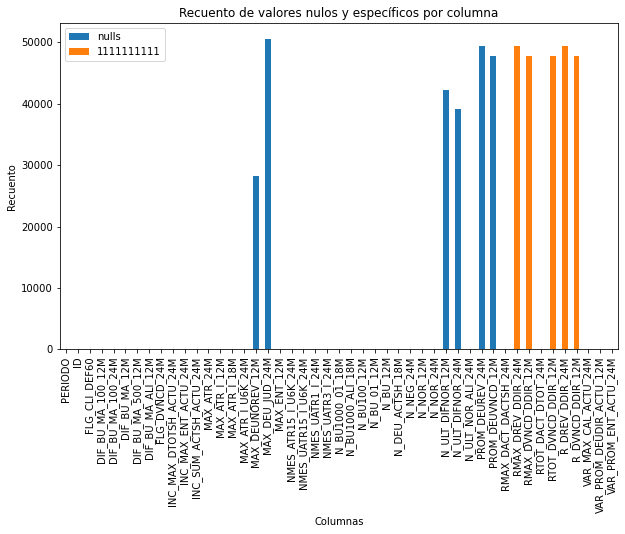

In [3]:
null_counts = data.isnull().sum()
counts_1111111111 = (data == 1111111111).sum()


# Crear un nuevo DataFrame con estos recuentos
counts_df = pd.DataFrame({'nulls': null_counts, '1111111111': counts_1111111111})

# Crear un gráfico de barras
counts_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el gráfico
plt.title('Recuento de valores nulos y específicos por columna')
plt.xlabel('Columnas')
plt.ylabel('Recuento')
plt.show()

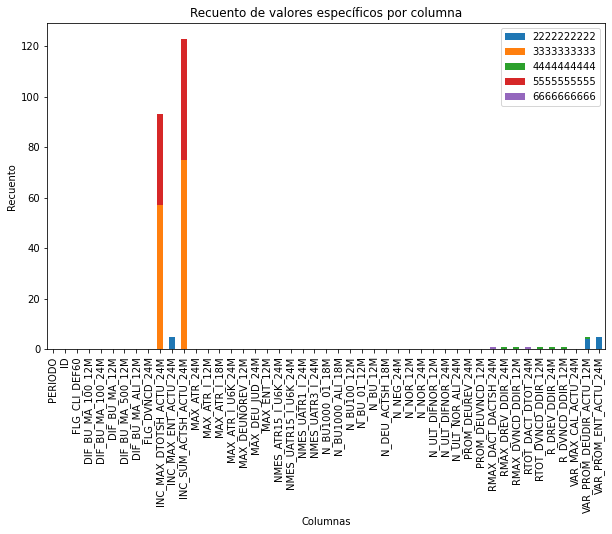

In [4]:
counts_2222222222 = (data == 2222222222).sum()
counts_3333333333 = (data == 3333333333).sum()
counts_5555555555 = (data == 5555555555).sum()
counts_4444444444 = (data == 4444444444).sum()
counts_6666666666 = (data == 6666666666).sum()
counts_df = pd.DataFrame({'2222222222':counts_2222222222,'3333333333': counts_3333333333, '4444444444':counts_4444444444,  '5555555555': counts_5555555555, '6666666666': counts_6666666666})
# Crear un gráfico de barras
counts_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el gráfico
plt.title('Recuento de valores específicos por columna')
plt.xlabel('Columnas')
plt.ylabel('Recuento')
plt.show()

Notas:
 - Todas las observaciones que tienen cero en la columna 'FLG_DVNCD_24M' tienen un '1111111111', en los ratios 'RMAX_DREV_DDIR_24M', 'RMAX_DVNCD_DDIR_12M', 'RTOT_DVNCD_DDIR_12M', 'R_DREV_DDIR_24M' y 'R_DVNCD_DDIR_12M'. Por esta razón, considero más útil reemplazarlos por cero en vez de realizar una imputación por promedio, media o moda 
 - Existen 4 observaciones con muchos datos faltantes (IDs: 15798, 22042, 36118, 48498). Al ser sólo 4 es preferible removerlos de la base.
 - Todas las observaciones con celdas vacías en las columnas referentes a montos o días de atraso se reemplazarán por ceros
 - Todas las observaciones con celdas vacías en las columnas referentes a número de meses desde la última clasificación también serán reemplazadas por ceros ya que asumo que los clientes han estado inactivos
 - Hay 57 observaciones con el valor '3333333333' o '5555555555' en la variable de aumento de la deuda, 75 en la variable 'INC_SUM_ACTSH_ACTU_24M' y 5 con el valor '2222222222' en la columna 'INC_MAX_ENT_ACTU_24M'. Podría ser mejor si quitamos estas observaciones de la base, pero se harán pruebas tanto sin las obs o con las observaciones reemplazando los errores por ceros. Me inclino más por quitarlos de la base por el hecho de que hay discrepancias entre los valores de incremento de la deuda e incremento del número de entidades acreedoras. Hay algunas observaciones que tienen un error en el incremento de deuda, pero muestran un aumento en la cantidad de entidades acreedoras, cosa que hace que el reemplazo por cero no tenga mucho sentido y me incline más por un error que debería ser removido.
 - Algo que también podría incluirse en el modelo es una serie de dummies que representen el periodo de estudio de la observación (columna periodo) para estudiar si el periodo tuvo algún efecto sobre el default de un cliente.

In [5]:
data_clean = data[data['DIF_BU_MA_100_12M'].notna()] # Eliminamos las 4 observaciones sin suficientes datos

# Reemplazamos estos valores especiales en los ratios por ceros
data_clean = data_clean.replace(1111111111,0) 
data_clean = data_clean.replace(4444444444,0) 
# Todas las observaciones con celdas vacías en las columnas referentes a montos o días de atraso se reemplazarán por ceros
# Todas las observaciones con celdas vacías en las columnas referentes a número de meses desde la última clasificación  
# también serán reemplazadas por ceros ya que asumo que los clientes han estado inactivos
data_clean = data_clean[(data_clean['INC_MAX_DTOTSH_ACTU_24M'] != 3333333333) & (data_clean['INC_MAX_DTOTSH_ACTU_24M'] != 5555555555)] 
data_clean = data_clean[(data_clean['INC_SUM_ACTSH_ACTU_24M'] != 3333333333) & (data_clean['INC_SUM_ACTSH_ACTU_24M'] != 5555555555)] 
data_clean['MAX_DEUNOREV_12M'] = data_clean['MAX_DEUNOREV_12M'].fillna(0)
data_clean['MAX_DEU_JUD_24M'] = data_clean['MAX_DEU_JUD_24M'].fillna(0)
data_clean['MAX_ENT_12M'] = data_clean['MAX_ENT_12M'].fillna(0)
data_clean['MAX_ATR_I_12M'] = data_clean['MAX_ATR_I_12M'].fillna(0)
data_clean['MAX_ATR_I_18M'] = data_clean['MAX_ATR_I_18M'].fillna(0)
data_clean['MAX_ATR_I_U6K_24M'] = data_clean['MAX_ATR_I_U6K_24M'].fillna(0)
data_clean['NMES_ATR15_I_U6K_24M'] = data_clean['NMES_ATR15_I_U6K_24M'].fillna(0)
data_clean['NMES_UATR15_I_U6K_24M'] = data_clean['NMES_UATR15_I_U6K_24M'].fillna(0)
data_clean['NMES_UATR1_I_24M'] = data_clean['NMES_UATR1_I_24M'].fillna(0)
data_clean['NMES_UATR3_I_24M'] = data_clean['NMES_UATR3_I_24M'].fillna(0)
data_clean['N_ULT_DIFNOR_12M'] = data_clean['N_ULT_DIFNOR_12M'].fillna(0)
data_clean['N_ULT_DIFNOR_24M'] = data_clean['N_ULT_DIFNOR_24M'].fillna(0)
data_clean['N_ULT_NOR_ALI_24M'] = data_clean['N_ULT_NOR_ALI_24M'].fillna(0)
data_clean['PROM_DEUREV_24M'] = data_clean['PROM_DEUREV_24M'].fillna(0)
data_clean['PROM_DEUVNCD_12M'] = data_clean['PROM_DEUVNCD_12M'].fillna(0)
data_clean['RTOT_DVNCD_DDIR_12M'] = data_clean['RTOT_DVNCD_DDIR_12M'].fillna(0)
data_clean['R_DVNCD_DDIR_12M'] = data_clean['R_DVNCD_DDIR_12M'].fillna(0)
data_clean['VAR_MAX_CAL_ACTU_24M'] = data_clean['VAR_MAX_CAL_ACTU_24M'].fillna(0)
data_clean['VAR_PROM_DEUDIR_ACTU_12M'] = data_clean['VAR_PROM_DEUDIR_ACTU_12M'].fillna(0)
data_clean['VAR_PROM_ENT_ACTU_24M'] = data_clean['VAR_PROM_ENT_ACTU_24M'].fillna(0)

In [6]:
data_clean.describe()

,PERIODO,ID,FLG_CLI_DEF60,DIF_BU_MA_100_12M,DIF_BU_MA_100_24M,DIF_BU_MA_12M,DIF_BU_MA_500_12M,DIF_BU_MA_ALI_12M,FLG_DVNCD_24M,INC_MAX_DTOTSH_ACTU_24M,...,RMAX_DACT_DACTSH_24M,RMAX_DREV_DDIR_24M,RMAX_DVNCD_DDIR_12M,RTOT_DACT_DTOT_24M,RTOT_DVNCD_DDIR_12M,R_DREV_DDIR_24M,R_DVNCD_DDIR_12M,VAR_MAX_CAL_ACTU_24M,VAR_PROM_DEUDIR_ACTU_12M,VAR_PROM_ENT_ACTU_24M
count,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,...,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000
mean,201725.954845,25307.436179,0.107223,10.364922,18.818173,10.382093,9.940625,10.706177,0.079991,0.936942,...,1.639331,0.006719,0.007806,0.861274,0.002130,0.010489,0.008341,0.060870,0.215436,-0.040200
std,38.568602,14615.123140,0.309399,3.126863,6.387534,3.123001,3.294865,2.712413,0.271282,6.019048,...,0.656472,0.054684,0.058003,0.189270,0.019229,0.095163,0.065646,0.161314,8.276837,0.277402
min,201701.000000,1.000000,0.000000,-12.000000,-24.000000,-12.000000,-12.000000,-12.000000,0.000000,0.000000,...,0.010597,0.000000,0.000000,0.006823,0.000000,0.000000,0.000000,0.000000,-0.886607,-0.733333
25%,201704.000000,12649.000000,0.000000,10.000000,15.000000,10.000000,9.000000,10.000000,0.000000,0.077094,...,1.238730,0.000000,0.000000,0.768429,0.000000,0.000000,0.000000,0.000000,-0.265640,-0.208333
50%,201708.000000,25312.000000,0.000000,12.000000,22.000000,12.000000,12.000000,12.000000,0.000000,0.307875,...,1.526375,0.000000,0.000000,0.959591,0.000000,0.000000,0.000000,0.000000,-0.002213,0.000000
75%,201712.000000,37965.000000,0.000000,12.000000,24.000000,12.000000,12.000000,12.000000,0.000000,0.835807,...,1.897398,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.304065,0.000000
max,201803.000000,50620.000000,1.000000,12.000000,24.000000,12.000000,12.000000,12.000000,1.000000,895.057348,...,13.998746,1.000000,1.000000,1.000000,1.000000,4.324849,3.335984,1.000000,1754.151667,2.863636


#### Comprobamos que no tenemos datos en blanco

In [7]:
rows_with_nan = data_clean.isna().any(axis=1)
print("Número de filas con valores vacíos:", rows_with_nan.sum())
if rows_with_nan.sum() > 0:
    print("\nFilas con valores vacíos:")
    print(data_clean[rows_with_nan])

Número de filas con valores vacíos: 0


#### Creamos dummies a partir de la variable PERIODO

- El punto de esto es estudiar si el periodo tiene un impacto en la probabilidad de default de un cliente


In [8]:
periodos = pd.get_dummies(data_clean['PERIODO'], prefix='PERIODO')
data_clean_final = pd.concat([data_clean, periodos], axis=1)
data_clean_final.drop('PERIODO', axis=1, inplace=True)


In [9]:
data_clean_final.tail()

,ID,FLG_CLI_DEF60,DIF_BU_MA_100_12M,DIF_BU_MA_100_24M,DIF_BU_MA_12M,DIF_BU_MA_500_12M,DIF_BU_MA_ALI_12M,FLG_DVNCD_24M,INC_MAX_DTOTSH_ACTU_24M,INC_MAX_ENT_ACTU_24M,...,PERIODO_201706,PERIODO_201707,PERIODO_201708,PERIODO_201709,PERIODO_201710,PERIODO_201711,PERIODO_201712,PERIODO_201801,PERIODO_201802,PERIODO_201803
50615,50616,1,8.0,20.0,8.0,8.0,8.0,1.0,0.540074,0.0,...,0,0,0,0,0,0,0,0,0,1
50616,50617,1,5.0,5.0,5.0,5.0,5.0,0.0,0.383603,0.0,...,0,0,0,0,0,0,0,0,0,1
50617,50618,1,12.0,14.0,12.0,12.0,12.0,0.0,0.157551,0.0,...,0,0,0,0,0,0,0,0,0,1
50618,50619,1,5.0,9.0,5.0,5.0,5.0,0.0,0.067838,0.0,...,0,0,0,0,0,0,0,0,0,1
50619,50620,1,5.0,5.0,5.0,5.0,5.0,0.0,4.160245,1.0,...,0,0,0,0,0,0,0,0,0,1


#### Importamos las librerías correspondientes

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve


In [11]:
data_clean_final.describe()

,ID,FLG_CLI_DEF60,DIF_BU_MA_100_12M,DIF_BU_MA_100_24M,DIF_BU_MA_12M,DIF_BU_MA_500_12M,DIF_BU_MA_ALI_12M,FLG_DVNCD_24M,INC_MAX_DTOTSH_ACTU_24M,INC_MAX_ENT_ACTU_24M,...,PERIODO_201706,PERIODO_201707,PERIODO_201708,PERIODO_201709,PERIODO_201710,PERIODO_201711,PERIODO_201712,PERIODO_201801,PERIODO_201802,PERIODO_201803
count,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,...,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000,50493.000000
mean,25307.436179,0.107223,10.364922,18.818173,10.382093,9.940625,10.706177,0.079991,0.936942,0.198789,...,0.066049,0.066227,0.066465,0.067158,0.066900,0.067039,0.067316,0.067138,0.067970,0.068406
std,14615.123140,0.309399,3.126863,6.387534,3.123001,3.294865,2.712413,0.271282,6.019048,0.429276,...,0.248370,0.248681,0.249095,0.250298,0.249852,0.250092,0.250571,0.250263,0.251697,0.252443
min,1.000000,0.000000,-12.000000,-24.000000,-12.000000,-12.000000,-12.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12649.000000,0.000000,10.000000,15.000000,10.000000,9.000000,10.000000,0.000000,0.077094,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25312.000000,0.000000,12.000000,22.000000,12.000000,12.000000,12.000000,0.000000,0.307875,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37965.000000,0.000000,12.000000,24.000000,12.000000,12.000000,12.000000,0.000000,0.835807,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50620.000000,1.000000,12.000000,24.000000,12.000000,12.000000,12.000000,1.000000,895.057348,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
data_clean_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50493 entries, 0 to 50619
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50493 non-null  int64  
 1   FLG_CLI_DEF60             50493 non-null  int64  
 2   DIF_BU_MA_100_12M         50493 non-null  float64
 3   DIF_BU_MA_100_24M         50493 non-null  float64
 4   DIF_BU_MA_12M             50493 non-null  float64
 5   DIF_BU_MA_500_12M         50493 non-null  float64
 6   DIF_BU_MA_ALI_12M         50493 non-null  float64
 7   FLG_DVNCD_24M             50493 non-null  float64
 8   INC_MAX_DTOTSH_ACTU_24M   50493 non-null  float64
 9   INC_MAX_ENT_ACTU_24M      50493 non-null  float64
 10  INC_SUM_ACTSH_ACTU_24M    50493 non-null  float64
 11  MAX_ATR_24M               50493 non-null  float64
 12  MAX_ATR_I_12M             50493 non-null  float64
 13  MAX_ATR_I_18M             50493 non-null  float64
 14  MAX_AT

In [13]:
Q1 = data_clean_final.quantile(0.25)
Q3 = data_clean_final.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (data_clean_final < lower_bound) | (data_clean_final > upper_bound)
data_clean_final[outliers.any(axis=1)]


,ID,FLG_CLI_DEF60,DIF_BU_MA_100_12M,DIF_BU_MA_100_24M,DIF_BU_MA_12M,DIF_BU_MA_500_12M,DIF_BU_MA_ALI_12M,FLG_DVNCD_24M,INC_MAX_DTOTSH_ACTU_24M,INC_MAX_ENT_ACTU_24M,...,PERIODO_201706,PERIODO_201707,PERIODO_201708,PERIODO_201709,PERIODO_201710,PERIODO_201711,PERIODO_201712,PERIODO_201801,PERIODO_201802,PERIODO_201803
0,1,0,12.0,20.0,12.0,10.0,12.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2,0,10.0,19.0,10.0,7.0,10.0,0.0,7.638805,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,3,0,8.0,8.0,8.0,7.0,8.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,4,0,12.0,24.0,12.0,12.0,12.0,0.0,0.149661,0.250000,...,0,0,0,0,0,0,0,0,0,0
4,5,0,12.0,24.0,12.0,12.0,12.0,0.0,0.771430,0.333333,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,50616,1,8.0,20.0,8.0,8.0,8.0,1.0,0.540074,0.000000,...,0,0,0,0,0,0,0,0,0,1
50616,50617,1,5.0,5.0,5.0,5.0,5.0,0.0,0.383603,0.000000,...,0,0,0,0,0,0,0,0,0,1
50617,50618,1,12.0,14.0,12.0,12.0,12.0,0.0,0.157551,0.000000,...,0,0,0,0,0,0,0,0,0,1
50618,50619,1,5.0,9.0,5.0,5.0,5.0,0.0,0.067838,0.000000,...,0,0,0,0,0,0,0,0,0,1


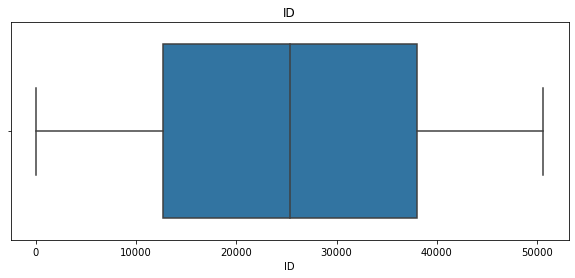

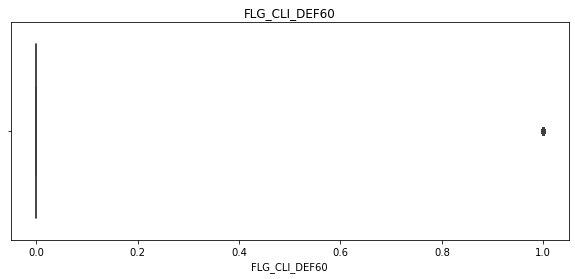

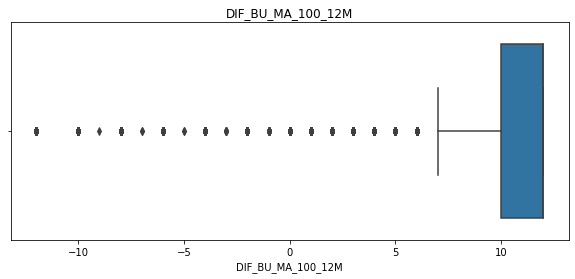

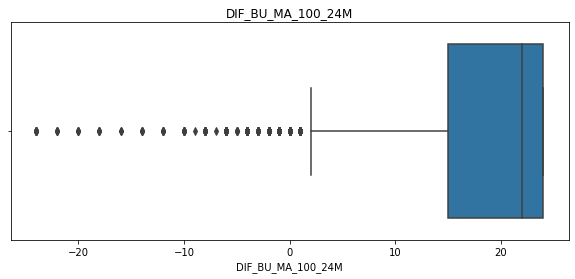

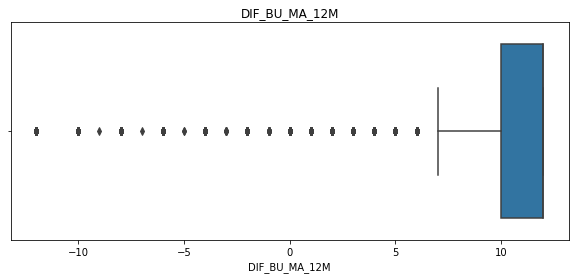

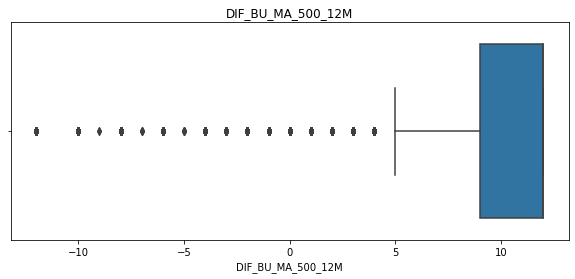

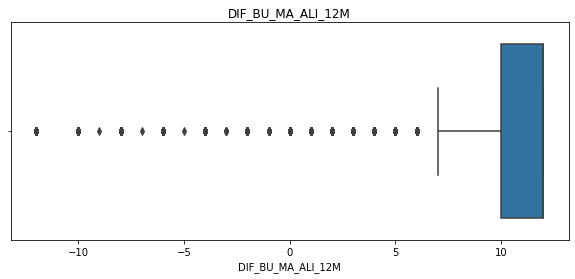

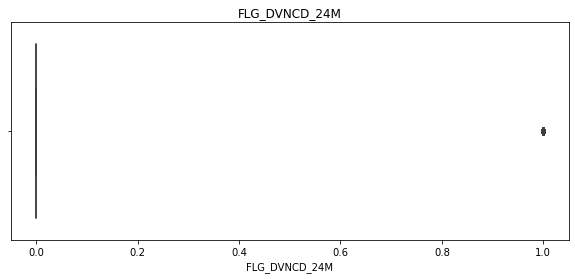

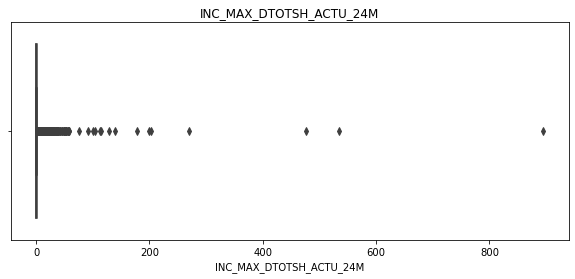

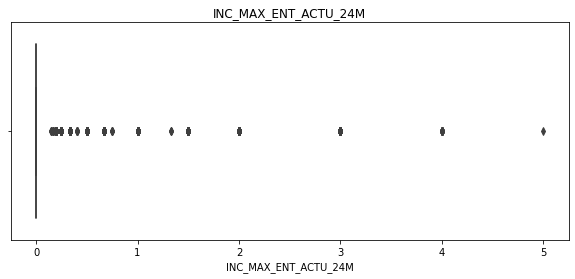

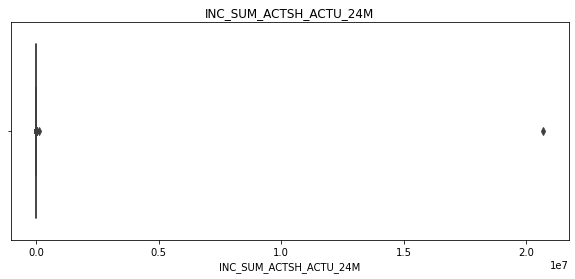

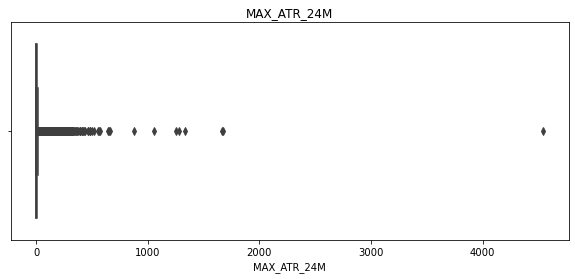

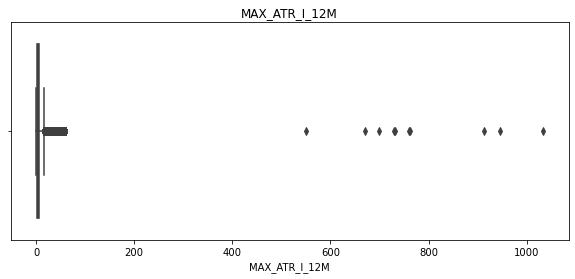

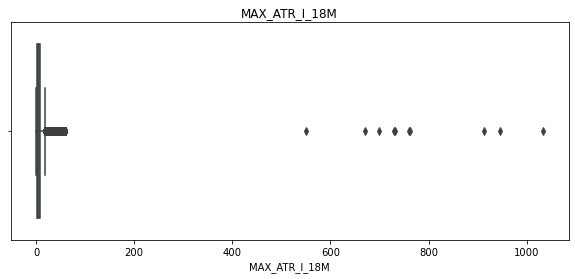

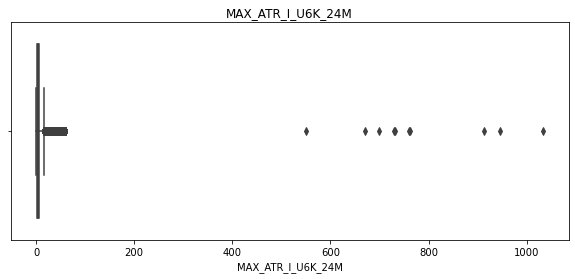

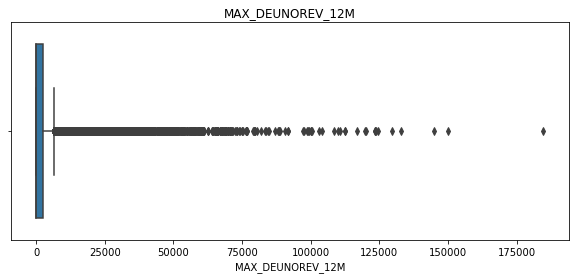

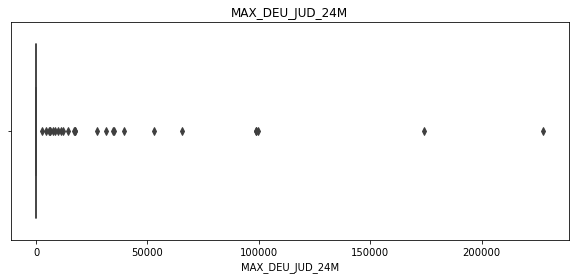

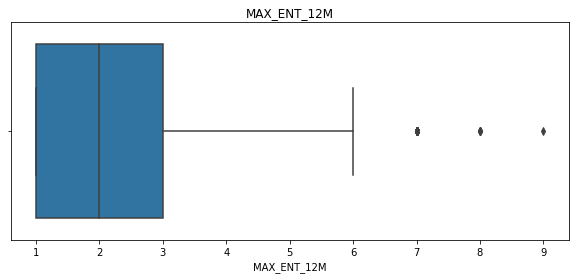

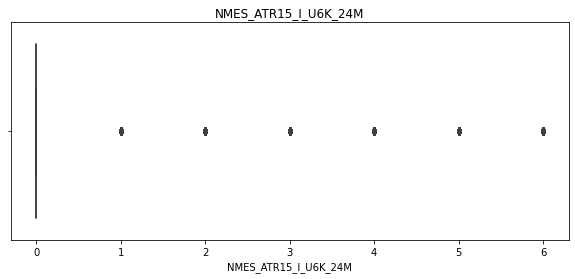

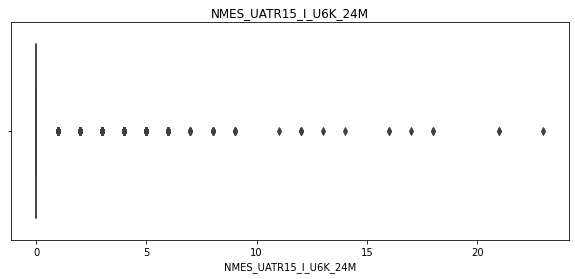

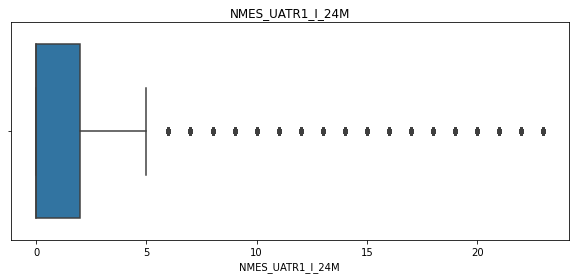

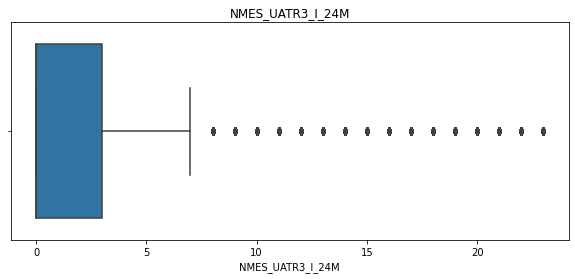

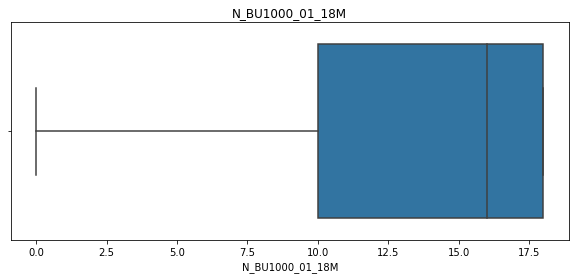

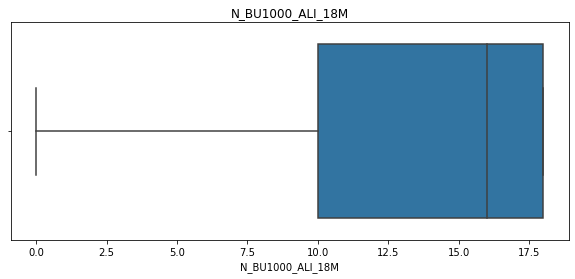

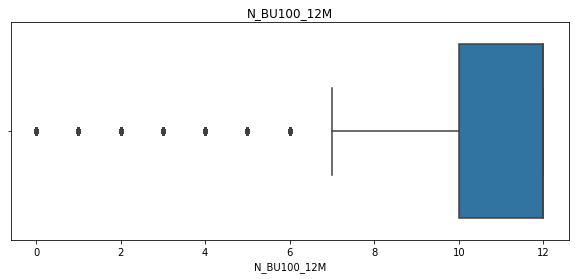

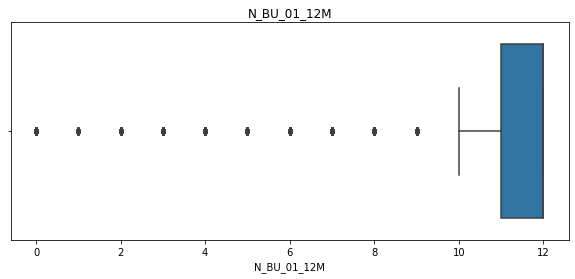

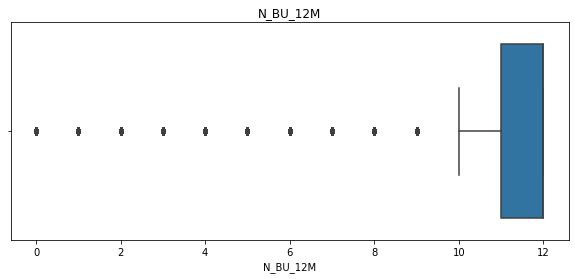

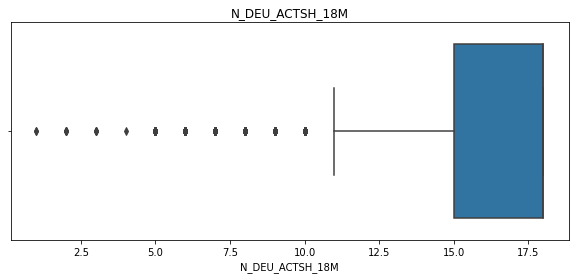

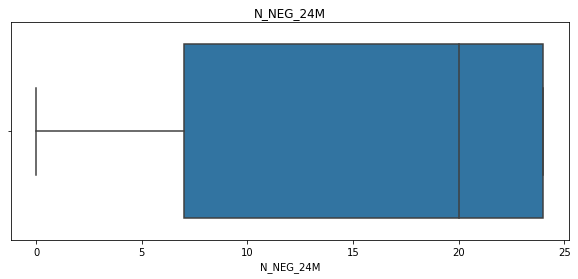

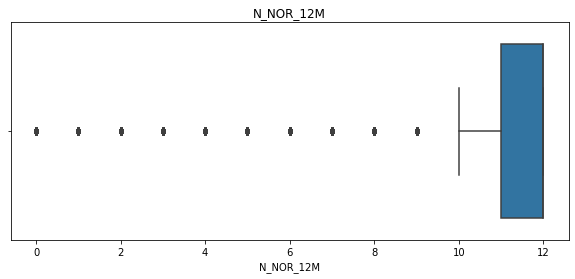

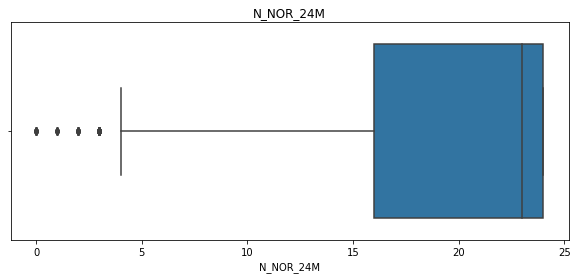

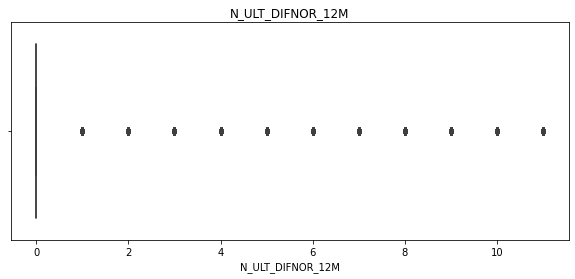

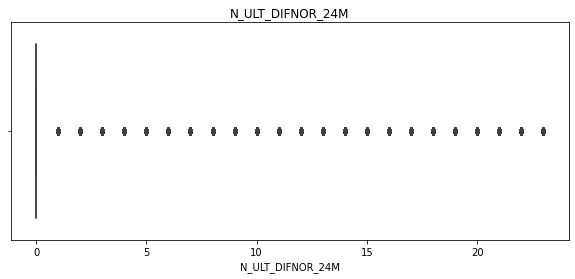

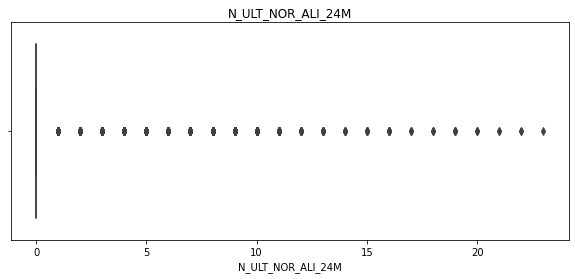

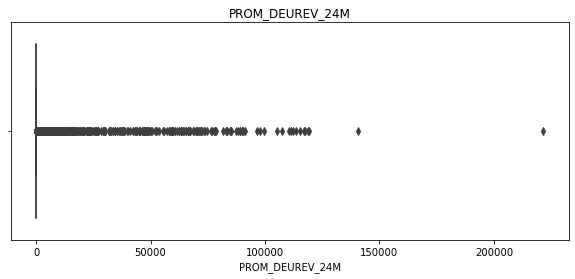

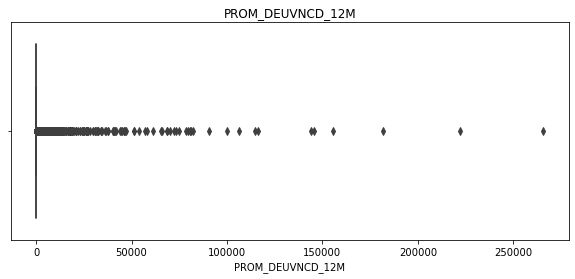

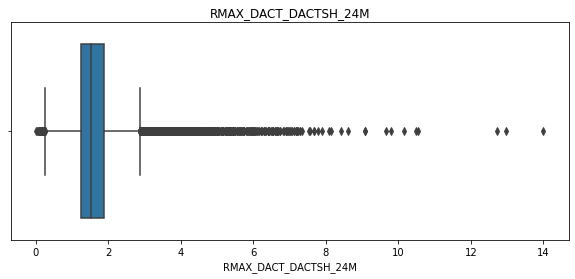

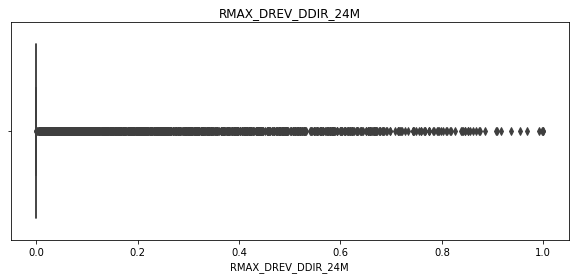

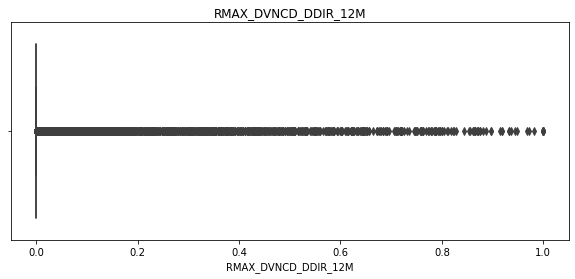

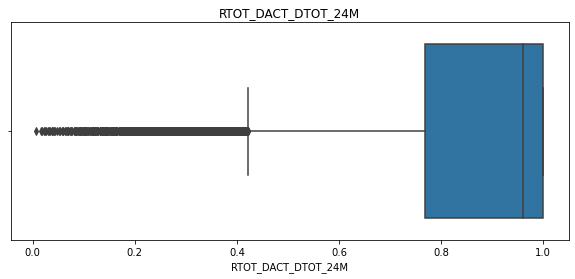

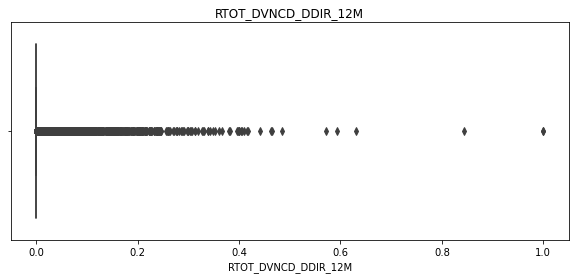

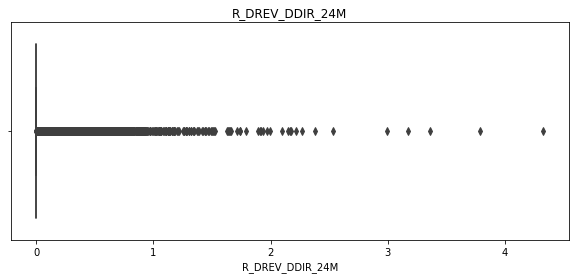

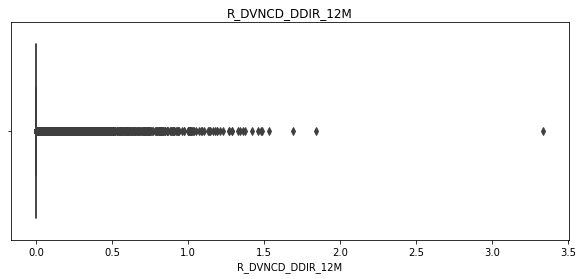

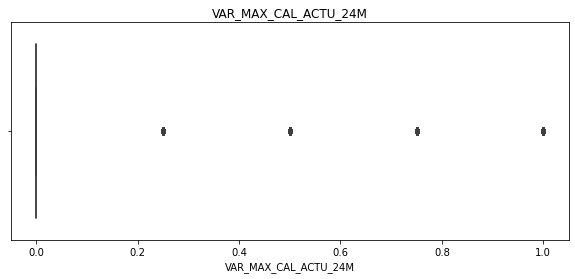

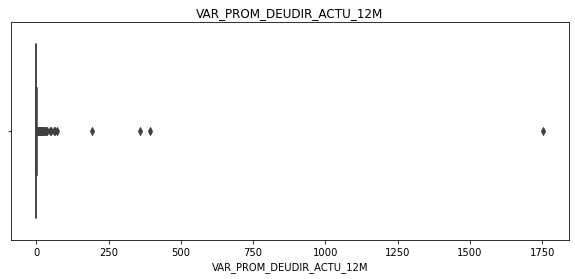

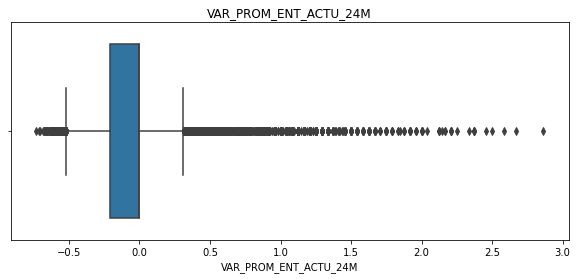

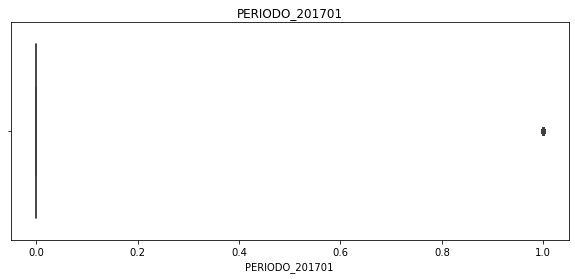

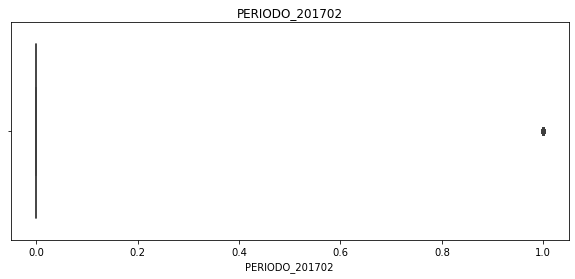

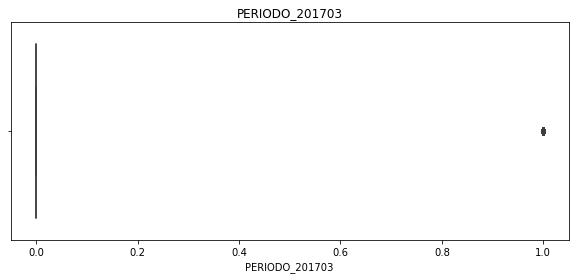

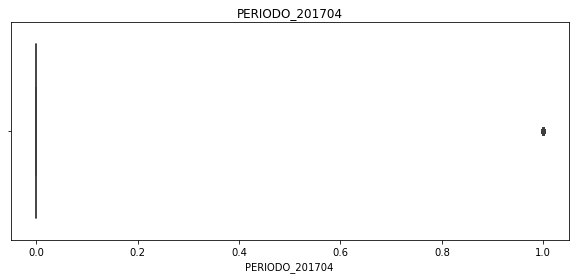

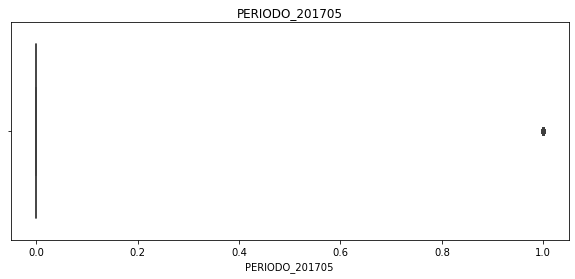

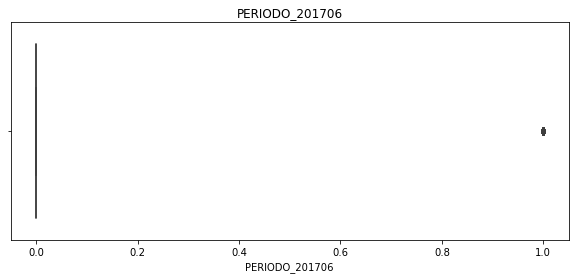

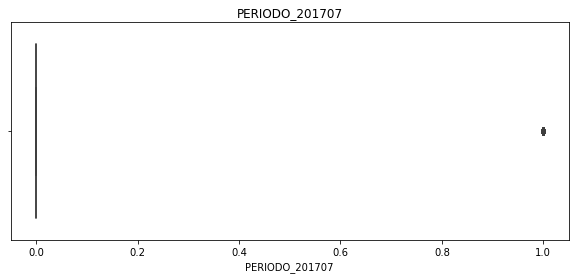

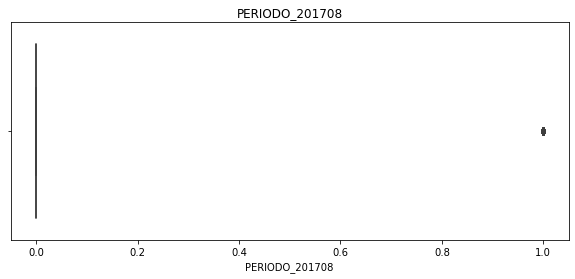

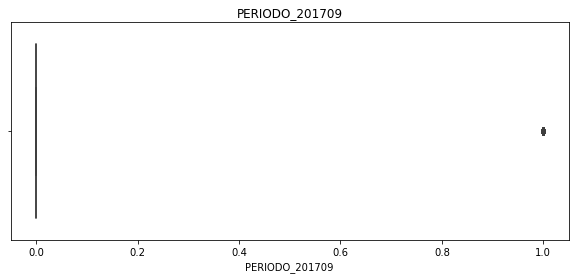

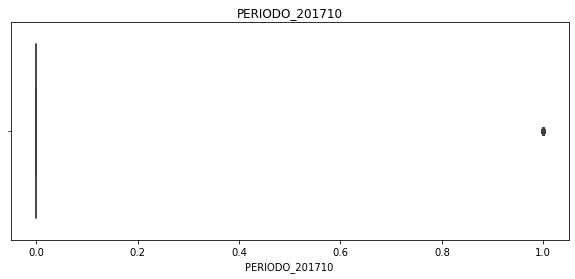

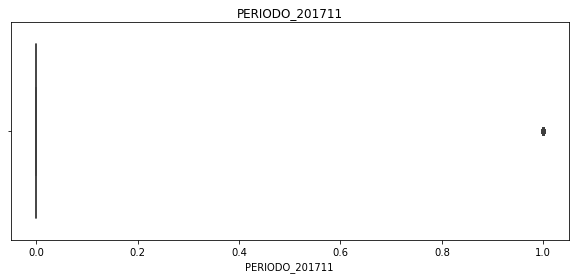

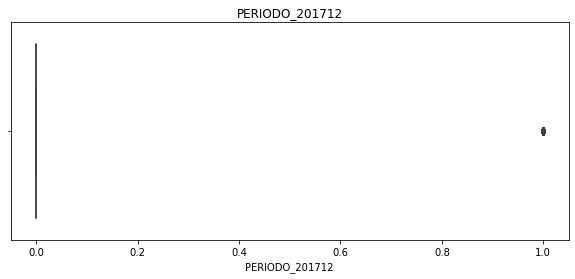

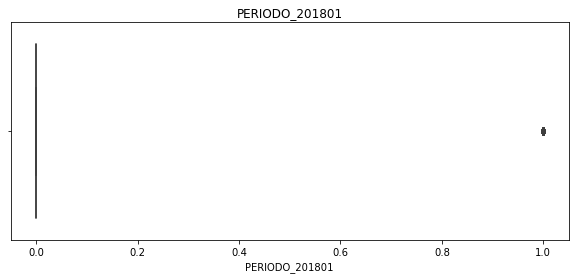

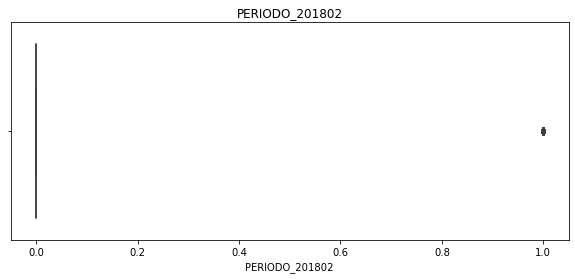

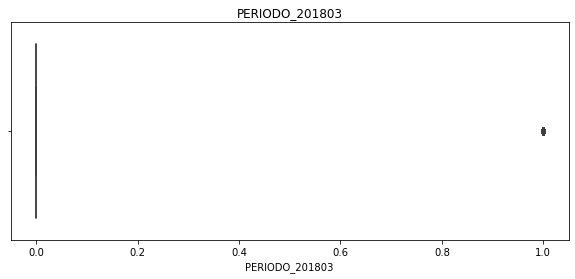

In [14]:
import seaborn as sns

for column in data_clean_final.columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data_clean_final[column])
    plt.title(column)
    plt.show()

# Se nota un claro sesgo hacia el no default en la base (posible desequilibrio).

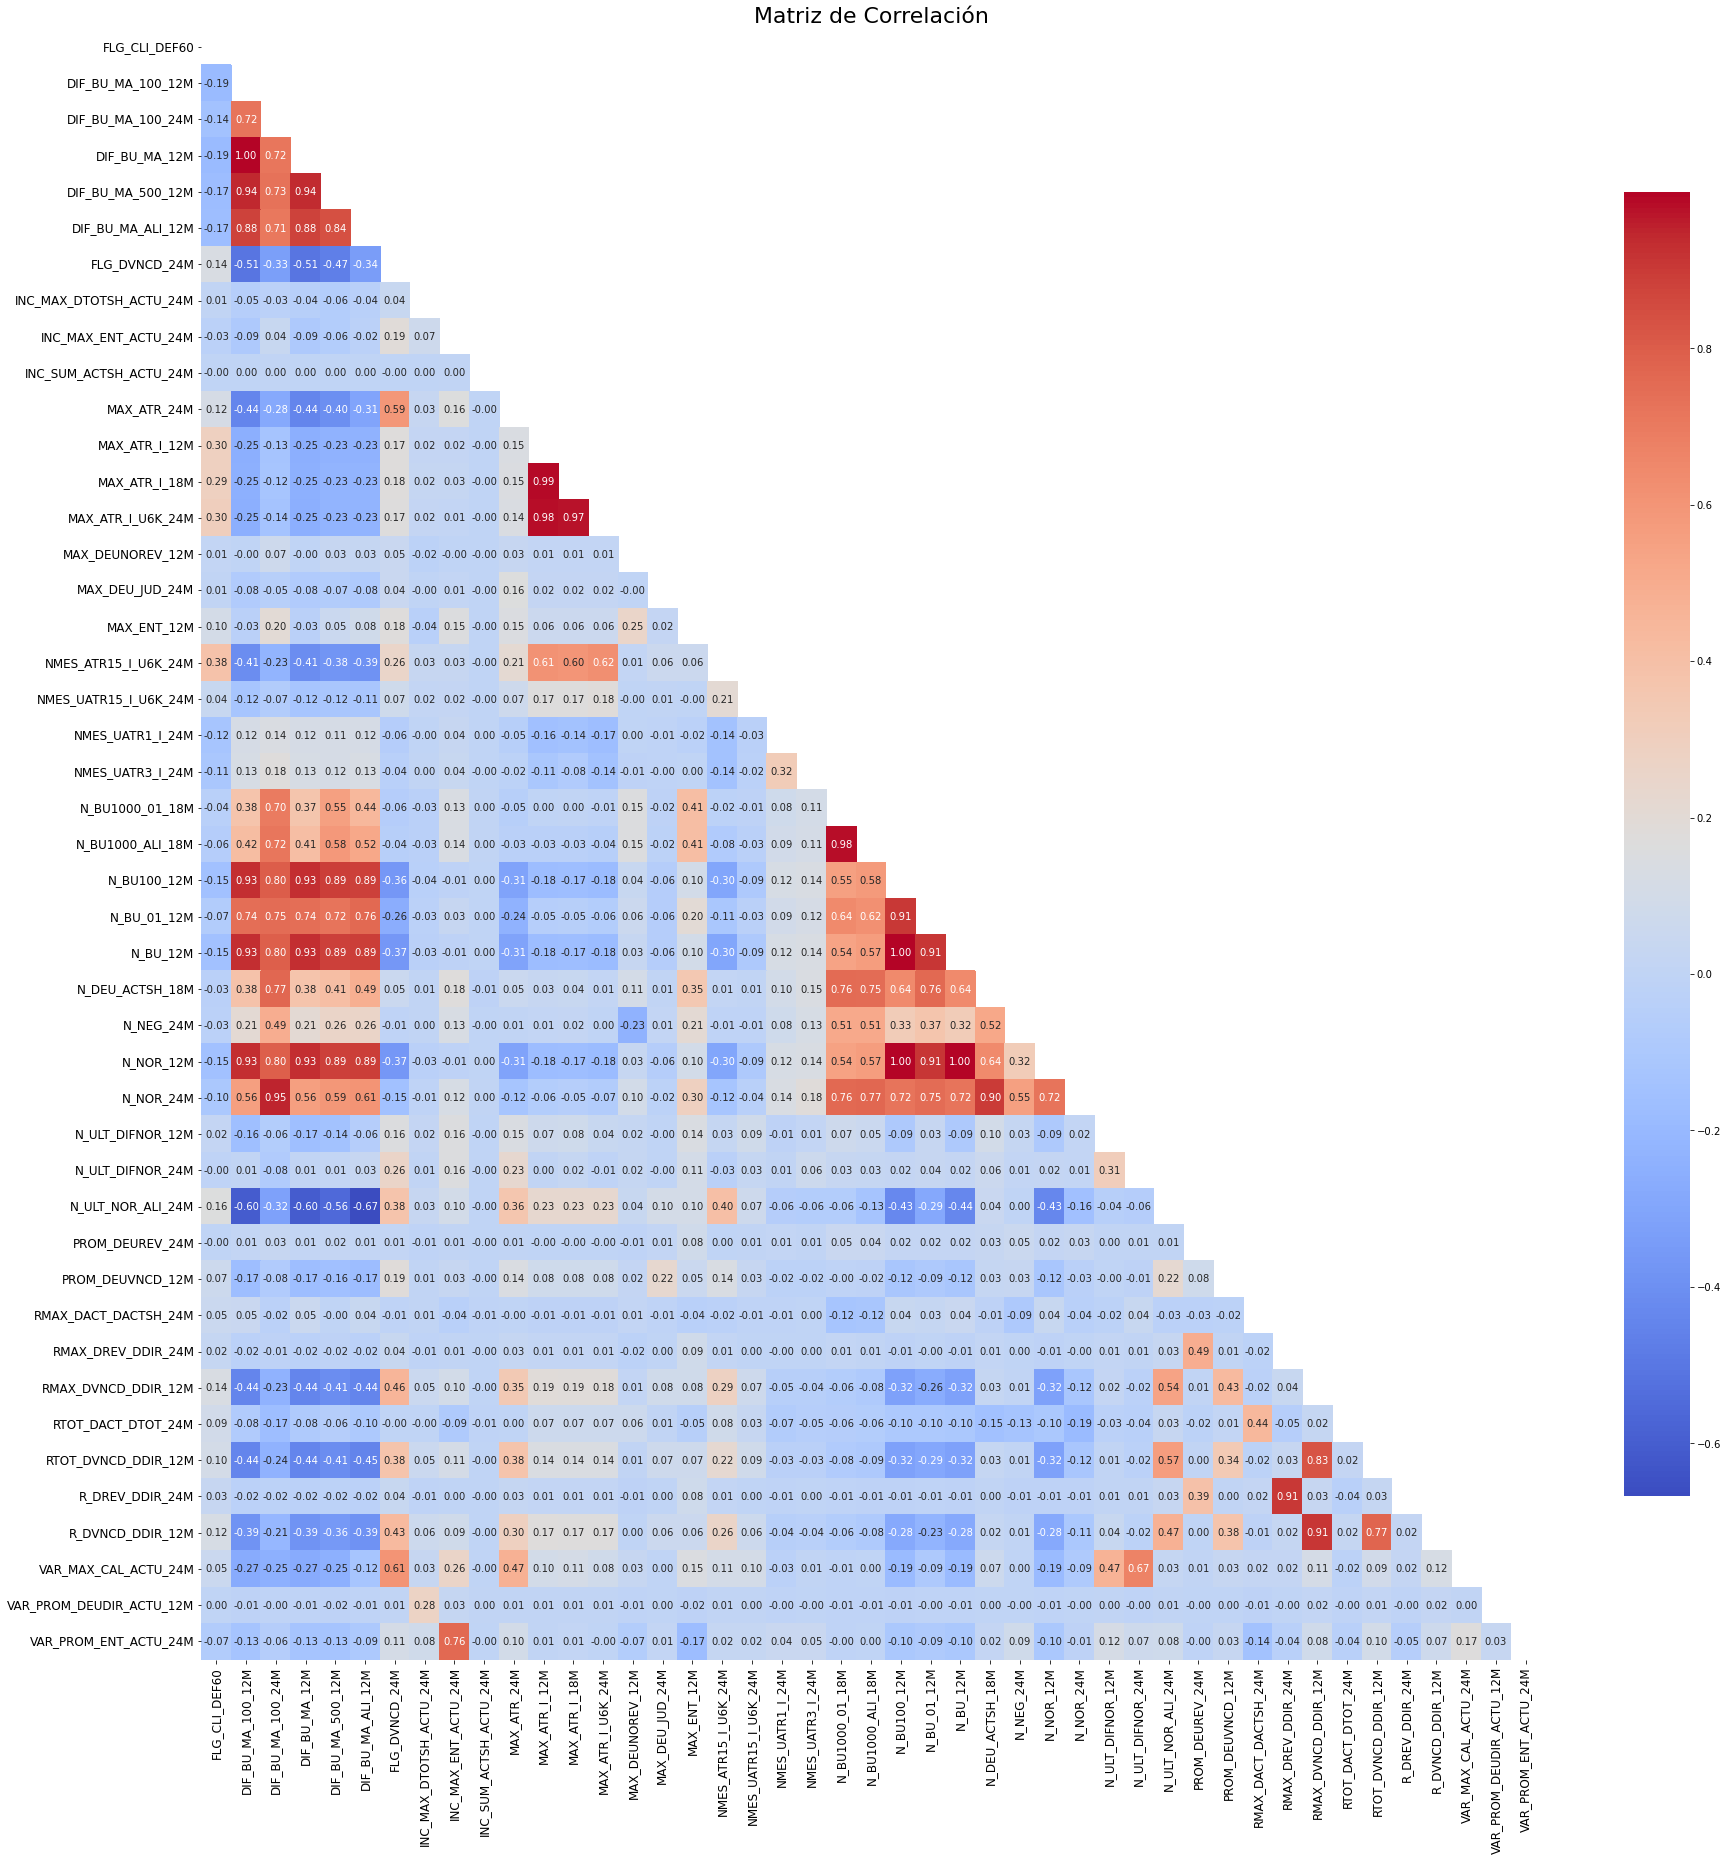

In [15]:
cols_to_include = [col for col in data_clean_final.columns if col not in periodos.columns.tolist() + ['ID']]

# Calcular la matriz de correlación
corr_matrix = data_clean_final[cols_to_include].corr()

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Configurar la figura de matplotlib
plt.figure(figsize=(30, 30))

# Dibujar el mapa de calor
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8})

# Añadir títulos y etiquetas
plt.title('Matriz de Correlación', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



Vemos que no hay relaciones muy directas entre las variables explicativas y el default, lo más cercano se encuentra en la variable NMES_ATR15_I_U6K_24M, que representa el número de meses con atrasos mayores o iguales a 15 días en los últimos 6 meses, y las variables de conteo de los máximos atrasos en diversos periodos de tiempo.
#### En sí, estas correlaciones me podrían estar diciendo que el modelo no podrá clasificar muy bien los casos de default. Tal vez existan otras variables que puedan explicar mejor la razón del atraso (género, edad, estudios, ingresos, ubigeo, duración, interés, etc)

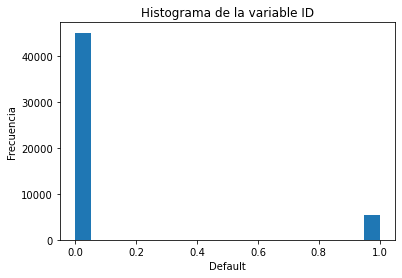

In [16]:
# Crear un histograma de la variable "FLG_CLI_DEF60"
plt.hist(data_clean_final['FLG_CLI_DEF60'], bins=20)
plt.xlabel('Default')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable ID')
plt.show()

## Empezamos a ver que existe un gran desequilibro en los datos. A considerar luego del entrenamiento piloto.

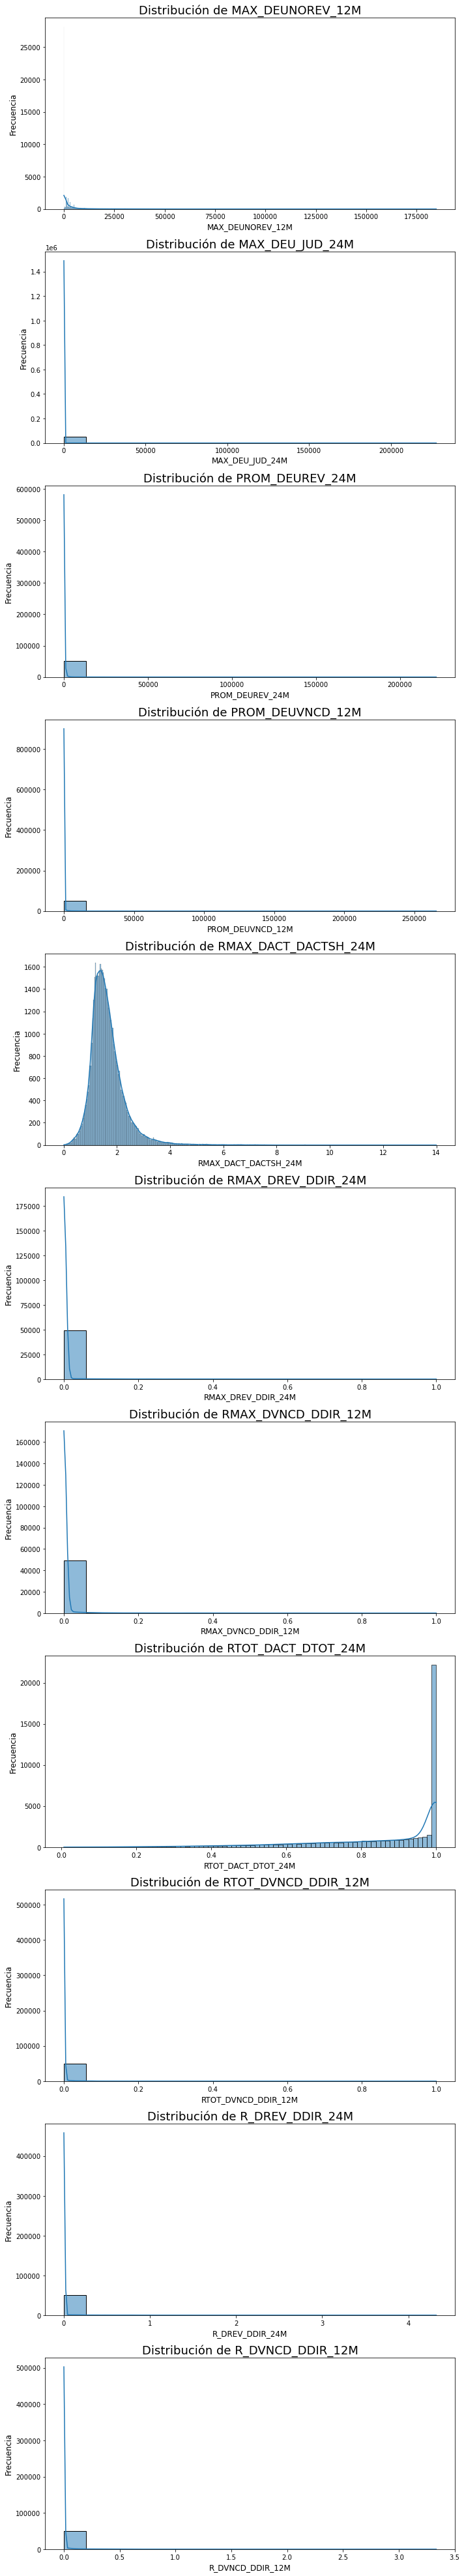

In [17]:
# Creamos una figura y ejes con matplotlib
cols_to_include = ['MAX_DEUNOREV_12M', 'MAX_DEU_JUD_24M', 'PROM_DEUREV_24M', 'PROM_DEUVNCD_12M', 
                   'RMAX_DACT_DACTSH_24M', 'RMAX_DREV_DDIR_24M', 'RMAX_DVNCD_DDIR_12M', 
                   'RTOT_DACT_DTOT_24M', 'RTOT_DVNCD_DDIR_12M', 'R_DREV_DDIR_24M', 'R_DVNCD_DDIR_12M']
fig, axs = plt.subplots(len(cols_to_include), figsize=(10,5*len(cols_to_include)))
# Para cada columna, crea un gráfico de distribución
for i, col in enumerate(cols_to_include):
    sns.histplot(data_clean_final[col], ax=axs[i], kde=True)
    axs[i].set_title('Distribución de '+col, fontsize=18)
    axs[i].set_xlabel(col, fontsize=12)
    axs[i].set_ylabel('Frecuencia', fontsize=12)
    
# Ajusta el layout
plt.tight_layout()
plt.show()
## Puede que normalizar algunas de estas variables ayude al entrenamiento. 
#(Al final el efecto no fue significativo así que no se mantuvo en este notebook)

In [18]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.1f}%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Autolabel sirve más adelante para mejorar los gráficos

### Entrenamiento Piloto y selección de la metodología más eficiente

In [19]:
# Separamos las características (X) y la variable objetivo (y)
X = data_clean_final.drop(['ID', 'FLG_CLI_DEF60'], axis=1)
y = data_clean_final['FLG_CLI_DEF60']

# Dividimos los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Entrenamiento y validación de cada modelo en el conjunto de validación
models = [
    ('Regresión Logística', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]
auc_scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append((name, auc))
    print(f'{name} AUC (validación): {auc}')

# Ordenamos los modelos por AUC en el conjunto de validación y seleccionamos el mejor
best_model_name, best_auc = sorted(auc_scores, key=lambda x: x[1], reverse=True)[0]
print(f'\nMejor modelo: {best_model_name} con AUC {best_auc}')

# Ajustar los hiperparámetros del mejor modelo
if best_model_name == 'Random Forest':
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist, cv=5, scoring='f1', n_jobs=-1, verbose=10, random_state=42)
elif best_model_name == 'XGBoost':
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1]
    }
    random_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_dist, cv=5, scoring='f1', n_jobs=-1, verbose=10, random_state=42)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f'\nMejores hiperparámetros: {best_params}')

# Estimamos las probabilidades y calculamos el AUC del mejor modelo ajustado
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
best_auc_tuned = roc_auc_score(y_test, y_pred_proba_best)
print(f'AUC del mejor modelo ajustado en el conjunto de prueba: {best_auc_tuned}')

# Calculamos las métricas de rendimiento
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
##
precision_pre = precision_score(y_test, y_pred)
recall_pre = recall_score(y_test, y_pred)
f1_pre = f1_score(y_test, y_pred)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

C:\Users\User\anaconda3\envs\T\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Regresión Logística AUC (validación): 0.7614709040140908
Random Forest AUC (validación): 0.8325280442405031
XGBoost AUC (validación): 0.8512153975017113

Mejor modelo: XGBoost con AUC 0.8512153975017113
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores hiperparámetros: {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
AUC del mejor modelo ajustado en el conjunto de prueba: 0.8338138195398216
Accuracy: 0.9076146153084463
Precision: 0.679324894514768
Recall: 0.29193109700815956
F1-score: 0.4083703233988586


#### Gráfico de las curvas ROC

In [20]:
# Función para graficar las curvas ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')

In [21]:
log_reg = LogisticRegression(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgb.fit(X_train, y_train)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_proba_rf = random_forest.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
# Calcular las curvas ROC para los modelos
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
log_reg_auc = roc_auc_score(y_test, y_pred_proba_log_reg)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)
#best_auc_tuned = roc_auc_score(y_test, y_pred_proba_best)

C:\Users\User\anaconda3\envs\T\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


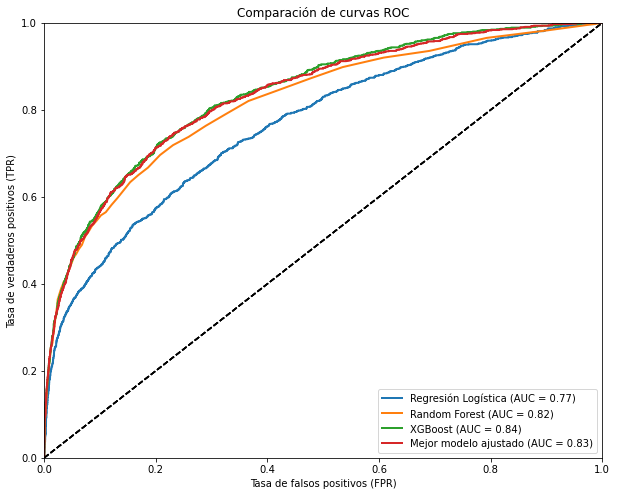

In [22]:
plt.figure(figsize=(10, 8))
plot_roc_curve(fpr_log_reg, tpr_log_reg, f'Regresión Logística (AUC = {log_reg_auc:.2f})')
plot_roc_curve(fpr_rf, tpr_rf, f'Random Forest (AUC = {rf_auc:.2f})')
plot_roc_curve(fpr_xgb, tpr_xgb, f'XGBoost (AUC = {xgb_auc:.2f})')
plot_roc_curve(fpr_best, tpr_best, f'Mejor modelo ajustado (AUC = {best_auc_tuned:.2f})')
plt.legend(loc='lower right')
plt.title('Comparación de curvas ROC')
plt.show()

#### Graficamos la distribución de las predicciones

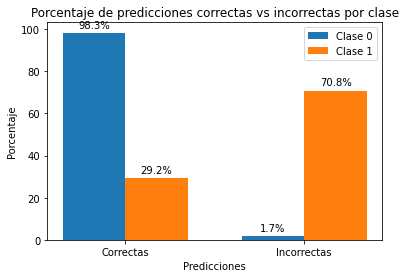

In [23]:
correct_predictions_0 = np.sum((y_test == y_pred) & (y_test == 0))
incorrect_predictions_0 = np.sum((y_test != y_pred) & (y_test == 0))
total_predictions_0 = np.sum(y_test == 0)

correct_predictions_1 = np.sum((y_test == y_pred) & (y_test == 1))
incorrect_predictions_1 = np.sum((y_test != y_pred) & (y_test == 1))
total_predictions_1 = np.sum(y_test == 1)

correct_percentage_0 = correct_predictions_0 / total_predictions_0 * 100
incorrect_percentage_0 = incorrect_predictions_0 / total_predictions_0 * 100

correct_percentage_1 = correct_predictions_1 / total_predictions_1 * 100
incorrect_percentage_1 = incorrect_predictions_1 / total_predictions_1 * 100

labels = ['Correctas', 'Incorrectas']
class_0_percentages = [correct_percentage_0, incorrect_percentage_0]
class_1_percentages = [correct_percentage_1, incorrect_percentage_1]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, class_0_percentages, width, label='Clase 0')
rects2 = ax.bar(x + width/2, class_1_percentages, width, label='Clase 1')

ax.set_xlabel("Predicciones")
ax.set_ylabel("Porcentaje")
ax.set_title("Porcentaje de predicciones correctas vs incorrectas por clase")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1, ax)
autolabel(rects2, ax)
plt.show()

In [24]:
print(f'Predicciones Correctas No Default {class_0_percentages}')
print(f'Predicciones Correctas Default {class_1_percentages}')

Predicciones Correctas No Default [98.31036016007114, 1.6896398399288575]
Predicciones Correctas Default [29.193109700815956, 70.80689029918405]


#### Optimización del umbral de clasificación

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)

# Calcula el F1-score para cada umbral
f1_scores = [f1_score(y_test, y_pred_proba_best >= t) for t in thresholds]

# Encuentra el índice del umbral óptimo (mayor F1-score)
optimal_threshold_index = np.argmax(f1_scores)

# Obtiene el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print(f"El umbral óptimo es: {optimal_threshold}")

El umbral óptimo es: 0.2578241229057312


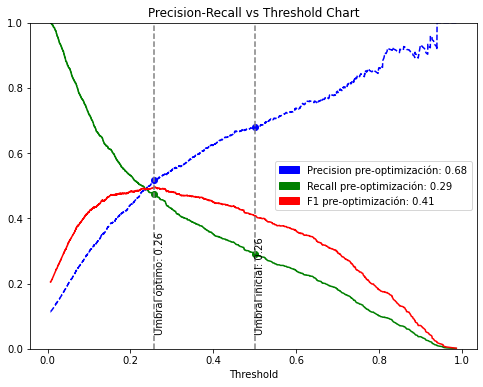

In [26]:
import matplotlib.patches as mpatches


# Crear un gráfico
plt.figure(figsize=(8, 6))
plt.title("Precision-Recall vs Threshold Chart")  # Agregado el título
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores, "r-", label="F1-Score")  # Añadido
plt.scatter(0.5, precision_pre, color='blue')  # Cambiado el color a naranja
plt.scatter(0.5, recall_pre, color='green')  # Cambiado el color a morado
plt.scatter(optimal_threshold, precision[optimal_threshold_index], color='blue')  # Cambiado el color a naranja
plt.scatter(optimal_threshold, recall[optimal_threshold_index], color='green')  # Cambiado el color a morado
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

# Agregar leyenda para los puntos
orange_patch = mpatches.Patch(color='blue', label=f'Precision pre-optimización: {precision_pre:.2f}')
purple_patch = mpatches.Patch(color='green', label=f'Recall pre-optimización: {recall_pre:.2f}')
red_patch = mpatches.Patch(color='red', label=f'F1 pre-optimización: {f1_pre:.2f}')
plt.legend(handles=[orange_patch, purple_patch, red_patch])

# Agregar el umbral óptimo al gráfico
plt.axvline(x=0.5, color='grey', linestyle='--')
plt.text(0.5, 0.05, f'Umbral inicial: {optimal_threshold:.2f}', rotation=90)
plt.axvline(x=optimal_threshold, color='grey', linestyle='--')
plt.text(optimal_threshold, 0.05, f'Umbral óptimo: {optimal_threshold:.2f}', rotation=90)

plt.show()

In [27]:
y_pred_optimal = (y_pred_proba_best >= optimal_threshold).astype(int)
# Calcular el accuracy
accuracy_optimal_threshold = accuracy_score(y_test, y_pred_optimal)
precision_optimal_threshold = precision_score(y_test, y_pred_optimal)
recall_optimal_threshold = recall_score(y_test, y_pred_optimal)
f1_optimal_threshold = f1_score(y_test, y_pred_optimal)
print("Accuracy Umbral Óptimo:", accuracy_optimal_threshold)
print("Precision Umbral Óptimo:", precision_optimal_threshold)
print("Recall Umbral Óptimo:", recall_optimal_threshold)
print("F1-score Umbral Óptimo:", f1_optimal_threshold)

Accuracy Umbral Óptimo: 0.8941479354391524
Precision Umbral Óptimo: 0.5167322834645669
Recall Umbral Óptimo: 0.4759746146872167
F1-score Umbral Óptimo: 0.49551675318546484


#### Gráfico comparativo del modelo antes y después de la optimización del umbral de clasificación

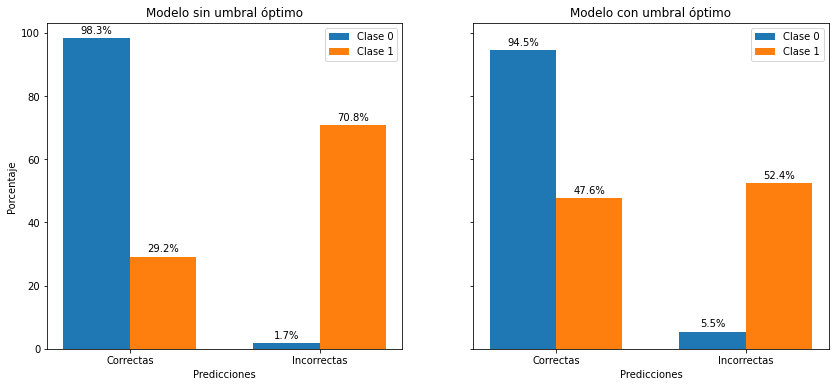

In [28]:
# Calcular las predicciones correctas e incorrectas para cada clase usando el umbral óptimo
correct_predictions_0_optimal = np.sum((y_test == y_pred_optimal) & (y_test == 0))
incorrect_predictions_0_optimal = np.sum((y_test != y_pred_optimal) & (y_test == 0))

correct_predictions_1_optimal = np.sum((y_test == y_pred_optimal) & (y_test == 1))
incorrect_predictions_1_optimal = np.sum((y_test != y_pred_optimal) & (y_test == 1))

# Calcular los porcentajes correctos e incorrectos para cada clase usando el umbral óptimo
correct_percentage_0_optimal = correct_predictions_0_optimal / total_predictions_0 * 100
incorrect_percentage_0_optimal = incorrect_predictions_0_optimal / total_predictions_0 * 100

correct_percentage_1_optimal = correct_predictions_1_optimal / total_predictions_1 * 100
incorrect_percentage_1_optimal = incorrect_predictions_1_optimal / total_predictions_1 * 100

# Crear un gráfico de barras para comparar el desempeño del modelo antes y después de aplicar el umbral óptimo
labels = ['Correctas', 'Incorrectas']
class_0_percentages_optimal = [correct_percentage_0_optimal, incorrect_percentage_0_optimal]
class_1_percentages_optimal = [correct_percentage_1_optimal, incorrect_percentage_1_optimal]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Gráfico de barras para el modelo antes de aplicar el umbral óptimo
rects1_original = ax1.bar(x - width/2, class_0_percentages, width, label='Clase 0')
rects2_original = ax1.bar(x + width/2, class_1_percentages, width, label='Clase 1')
ax1.set_title("Modelo sin umbral óptimo")
ax1.set_xlabel("Predicciones")
ax1.set_ylabel("Porcentaje")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
autolabel(rects1_original, ax1)
autolabel(rects2_original, ax1)

# Gráfico de barras para el modelo después de aplicar el umbral óptimo
rects1_optimal = ax2.bar(x - width/2, class_0_percentages_optimal, width, label='Clase 0')
rects2_optimal = ax2.bar(x + width/2, class_1_percentages_optimal, width, label='Clase 1')
ax2.set_title("Modelo con umbral óptimo")
ax2.set_xlabel("Predicciones")
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
autolabel(rects1_optimal, ax2)
autolabel(rects2_optimal, ax2)

plt.show()

In [29]:
print(f'Predicciones Correctas No Default {class_0_percentages_optimal}')
print(f'Predicciones Correctas Default {class_1_percentages_optimal}')

Predicciones Correctas No Default [94.54201867496666, 5.457981325033348]
Predicciones Correctas Default [47.59746146872167, 52.40253853127833]


### Predicción de probabilidades e Integración a la gestión

In [30]:
# Predecir las clases usando el umbral óptimo (0.23 - Minimizamos el riesgo)
probs_total = best_model.predict_proba(X)[:, 1]
probs_test = best_model.predict_proba(X_test)[:, 1]
predictions_optimal = np.where(probs_test >= optimal_threshold, 1, 0)

# Predecir las clases usando el umbral de 0.5 (Modelo Base)
predictions_05 = np.where(probs_test >= 0.5, 1, 0)

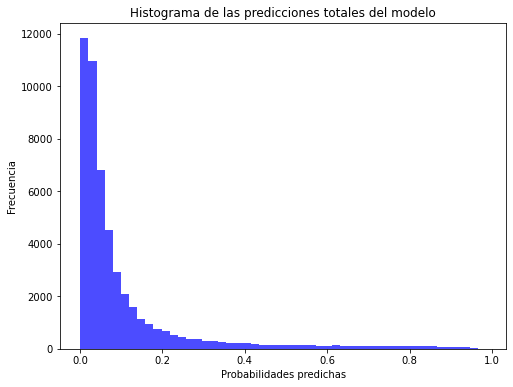

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(probs_total, bins=50, color='blue', alpha=0.7)
plt.xlabel('Probabilidades predichas')
plt.ylabel('Frecuencia')
plt.title('Histograma de las predicciones totales del modelo')
plt.show()

In [32]:
# Asumimos una tasa de interés del 10%
interest_rate = 0.1

# Asumimos que el monto del préstamo es la deuda máxima
loan_amount = X_test['MAX_DEUNOREV_12M']

# Calculamos las ganancias y pérdidas para el umbral óptimo
true_positives = (predictions_optimal == 1) & (y_test == 1)
false_positives = (predictions_optimal == 1) & (y_test == 0)
true_negatives = (predictions_optimal == 0) & (y_test == 0)
false_negatives = (predictions_optimal == 0) & (y_test == 1)

# Ganancias: Intereses de los préstamos correctamente clasificados como 0 (buenos clientes)
gains = np.sum(loan_amount[true_negatives] * interest_rate)

# Pérdidas: Monto total de los préstamos incorrectamente clasificados como 0 (malos clientes)
losses = np.sum(loan_amount[false_negatives])

# Ganancia neta
net_gain = gains - losses

print(f"Ganancia neta utilizando el umbral óptimo: {net_gain:.2f}")

Ganancia neta utilizando el umbral óptimo: 564319.95


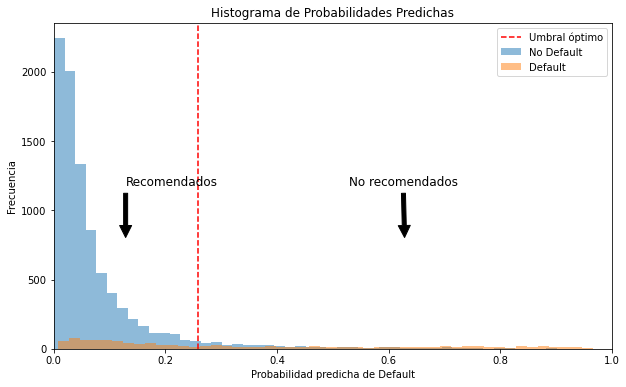

In [33]:
# Calcular las probabilidades predichas para la base de testeo
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# Crear el histograma
plt.figure(figsize=(10,6))
plt.hist(y_pred_proba[y_test==0], bins=50, label='No Default', alpha=0.5)
plt.hist(y_pred_proba[y_test==1], bins=50, label='Default', alpha=0.5)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label='Umbral óptimo')

# Crear una anotación para indicar a quiénes se les recomendaría
plt.annotate('Recomendados', xy=(optimal_threshold/2, plt.ylim()[1]/3), 
             xytext=(optimal_threshold/2, plt.ylim()[1]/2), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')
plt.annotate('No recomendados', xy=((1+optimal_threshold)/2, plt.ylim()[1]/3), 
             xytext=((0.8+optimal_threshold)/2, plt.ylim()[1]/2), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')

# Configurar el gráfico
plt.xlabel('Probabilidad predicha de Default')
plt.ylabel('Frecuencia')
plt.title('Histograma de Probabilidades Predichas')
plt.legend(loc="upper right")
plt.xlim([0,1])  # Aseguramos que el gráfico se muestre completamente en el rango de 0 a 1
plt.show()

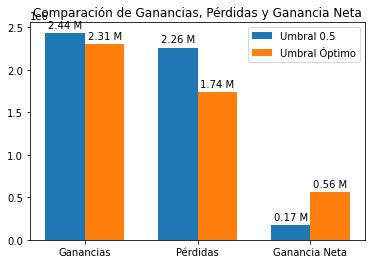

In [34]:
# Calcular las predicciones para el umbral de 0.5
predictions_05 = np.where(probs_test >= 0.5, 1, 0)

# Identificar verdaderos y falsos positivos y negativos para el umbral de 0.5
true_positives_05 = (predictions_05 == 1) & (y_test == 1)
false_positives_05 = (predictions_05 == 1) & (y_test == 0)
true_negatives_05 = (predictions_05 == 0) & (y_test == 0)
false_negatives_05 = (predictions_05 == 0) & (y_test == 1)

# Ganancias y pérdidas para el umbral de 0.5
gains_05 = np.sum(loan_amount[true_negatives_05] * interest_rate)
losses_05 = np.sum(loan_amount[false_negatives_05])
net_gain_05 = gains_05 - losses_05

# Crear un gráfico de barras
bar_width = 0.35
labels = ['Ganancias', 'Pérdidas', 'Ganancia Neta']
umbral_05 = [gains_05, losses_05, net_gain_05]
umbral_optimal = [gains, losses, net_gain]

fig, ax = plt.subplots()
bar1 = ax.bar(np.arange(len(umbral_05)), umbral_05, bar_width, label='Umbral 0.5')
bar2 = ax.bar(np.arange(len(umbral_optimal)) + bar_width, umbral_optimal, bar_width, label='Umbral Óptimo')

ax.set_xticks(np.arange(len(umbral_05)) + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

def autolabel2(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f} M'.format(height/1e6),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # desplazamiento vertical en puntos
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel2(bar1)
autolabel2(bar2)

plt.title("Comparación de Ganancias, Pérdidas y Ganancia Neta")
plt.show()

In [35]:
LGD = 1  # Asumimos que no recuperamos nada en caso de incumplimiento

# Usamos las predicciones de probabilidad de nuestro modelo como la PD
PD = best_model.predict_proba(X_test)[:, 1]

# Usamos el valor de la deuda como la EAD
EAD = X_test['MAX_DEUNOREV_12M']

# Calculamos la pérdida esperada
expected_loss = PD * EAD * LGD
print(f'La pérdida esperada en este modelo sería:{expected_loss.sum()}')

La pérdida esperada en este modelo sería:3495196.3403997812


## Modelo con resampling (mismo proceso de entrenamiento)

In [36]:
from sklearn.utils import resample

# Concatenar X_train e y_train en un único DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separar las clases mayoritaria y minoritaria
majority_class = train_data[train_data['FLG_CLI_DEF60'] == 0]
minority_class = train_data[train_data['FLG_CLI_DEF60'] == 1]

# Aplicar submuestreo a la clase mayoritaria
majority_class_downsampled = resample(majority_class, 
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria submuestreada
downsampled_data = pd.concat([majority_class_downsampled, minority_class])

# Separar nuevamente en X_train e y_train
X_train_downsampled = downsampled_data.drop('FLG_CLI_DEF60', axis=1)
y_train_downsampled = downsampled_data['FLG_CLI_DEF60']
# Entrenar y evaluar el modelo utilizando los datos submuestreados
models = [
    ('Regresión Logística', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]
auc_scores = []
for name, model in models:
    model.fit(X_train_downsampled, y_train_downsampled)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append((name, auc))
    print(f'{name} AUC: {auc}')
# Ordenar los modelos por AUC y seleccionar el mejor
best_model_name, best_auc = sorted(auc_scores, key=lambda x: x[1], reverse=True)[0]
print(f'\nMejor modelo: {best_model_name} con AUC {best_auc}')
# Ajustar los hiperparámetros del mejor modelo
if best_model_name == 'Random Forest':
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist, cv=5, scoring='f1', n_jobs=-1, verbose=10, random_state=42)
elif best_model_name == 'XGBoost':
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1]
    }
    random_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_dist, cv=5, scoring='f1', n_jobs=-1, verbose=10, random_state=42)

random_search.fit(X_train_downsampled, y_train_downsampled)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f'\nMejores hiperparámetros: {best_params}')
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
best_auc_tuned = roc_auc_score(y_test, y_pred_proba_best)
print(f'AUC del mejor modelo ajustado: {best_auc_tuned}')
log_reg = LogisticRegression(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
log_reg.fit(X_train_downsampled, y_train_downsampled)
random_forest.fit(X_train_downsampled, y_train_downsampled)
xgb.fit(X_train_downsampled, y_train_downsampled)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_proba_rf = random_forest.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
# Calcular las curvas ROC para los modelos
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
log_reg_auc = roc_auc_score(y_test, y_pred_proba_log_reg)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)
#best_auc_tuned = roc_auc_score(y_test, y_pred_proba_best)

Regresión Logística AUC: 0.8003443254925025


C:\Users\User\anaconda3\envs\T\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Random Forest AUC: 0.8278591734333824
XGBoost AUC: 0.8335928590404036

Mejor modelo: XGBoost con AUC 0.8335928590404036
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores hiperparámetros: {'subsample': 0.5, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
AUC del mejor modelo ajustado: 0.8376109136043942


C:\Users\User\anaconda3\envs\T\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


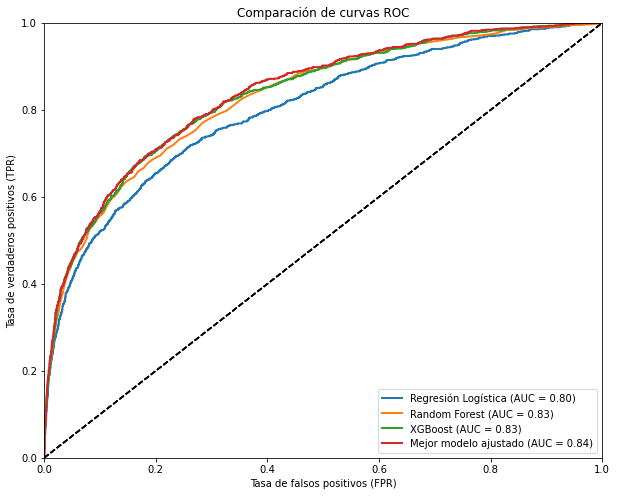

In [37]:
plt.figure(figsize=(10, 8))
plot_roc_curve(fpr_log_reg, tpr_log_reg, f'Regresión Logística (AUC = {log_reg_auc:.2f})')
plot_roc_curve(fpr_rf, tpr_rf, f'Random Forest (AUC = {rf_auc:.2f})')
plot_roc_curve(fpr_xgb, tpr_xgb, f'XGBoost (AUC = {xgb_auc:.2f})')
plot_roc_curve(fpr_best, tpr_best, f'Mejor modelo ajustado (AUC = {best_auc_tuned:.2f})')
plt.legend(loc='lower right')
plt.title('Comparación de curvas ROC')
plt.show()

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Calcular el recall
recall = recall_score(y_test, y_pred)

# Calcular el F1-score
f1 = f1_score(y_test, y_pred)
precision_pre = precision_score(y_test, y_pred)
recall_pre = recall_score(y_test, y_pred)
f1_pre = f1_score(y_test, y_pred)
# Imprimir las métricas
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7962174472720072
Precision: 0.3093812375249501
Recall: 0.7026291931097008
F1-score: 0.4296008869179601


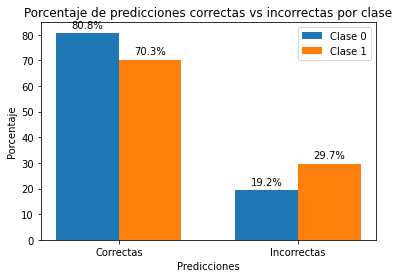

In [39]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
# Calcula la proporción de predicciones correctas e incorrectas para cada clase
correct_predictions_0 = np.sum((y_test == y_pred) & (y_test == 0))
incorrect_predictions_0 = np.sum((y_test != y_pred) & (y_test == 0))
total_predictions_0 = np.sum(y_test == 0)

correct_predictions_1 = np.sum((y_test == y_pred) & (y_test == 1))
incorrect_predictions_1 = np.sum((y_test != y_pred) & (y_test == 1))
total_predictions_1 = np.sum(y_test == 1)

# Calcula los porcentajes
correct_percentage_0 = correct_predictions_0 / total_predictions_0 * 100
incorrect_percentage_0 = incorrect_predictions_0 / total_predictions_0 * 100

correct_percentage_1 = correct_predictions_1 / total_predictions_1 * 100
incorrect_percentage_1 = incorrect_predictions_1 / total_predictions_1 * 100

# Crea el gráfico de barras agrupadas
labels = ['Correctas', 'Incorrectas']
class_0_percentages = [correct_percentage_0, incorrect_percentage_0]
class_1_percentages = [correct_percentage_1, incorrect_percentage_1]

x = np.arange(len(labels))  # Ubicación de las etiquetas
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, class_0_percentages, width, label='Clase 0')
rects2 = ax.bar(x + width/2, class_1_percentages, width, label='Clase 1')

# Añade texto, etiquetas, título y leyenda
ax.set_xlabel("Predicciones")
ax.set_ylabel("Porcentaje")
ax.set_title("Porcentaje de predicciones correctas vs incorrectas por clase")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1, ax)
autolabel(rects2, ax)
# Muestra el gráfico
plt.show()

In [40]:
print(f'Predicciones Correctas No Default {class_0_percentages}')
print(f'Predicciones Correctas Default {class_1_percentages}')

Predicciones Correctas No Default [80.76923076923077, 19.230769230769234]
Predicciones Correctas Default [70.26291931097009, 29.73708068902992]


In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)

# Calcula el F1-score para cada umbral
f1_scores = [f1_score(y_test, y_pred_proba_best >= t) for t in thresholds]

# Encuentra el índice del umbral óptimo (mayor F1-score)
optimal_threshold_index = np.argmax(f1_scores)

# Obtiene el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print(f"El umbral óptimo es: {optimal_threshold}")

El umbral óptimo es: 0.7190038561820984


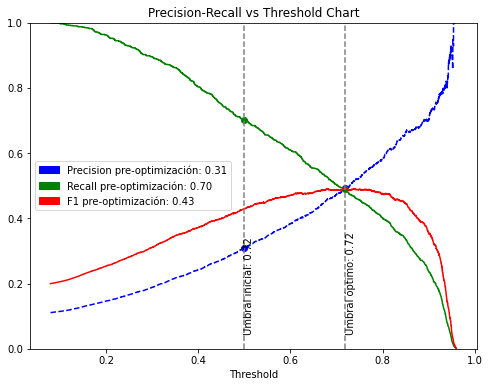

In [42]:
# Crear un gráfico
plt.figure(figsize=(8, 6))
plt.title("Precision-Recall vs Threshold Chart")  # Agregado el título
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores, "r-", label="F1-Score")  # Añadido
plt.scatter(0.5, precision_pre, color='blue')  # Cambiado el color a naranja
plt.scatter(0.5, recall_pre, color='green')  # Cambiado el color a morado
plt.scatter(optimal_threshold, precision[optimal_threshold_index], color='blue')  # Cambiado el color a naranja
plt.scatter(optimal_threshold, recall[optimal_threshold_index], color='green')  # Cambiado el color a morado
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

# Agregar leyenda para los puntos
orange_patch = mpatches.Patch(color='blue', label=f'Precision pre-optimización: {precision_pre:.2f}')
purple_patch = mpatches.Patch(color='green', label=f'Recall pre-optimización: {recall_pre:.2f}')
red_patch = mpatches.Patch(color='red', label=f'F1 pre-optimización: {f1_pre:.2f}')
plt.legend(handles=[orange_patch, purple_patch, red_patch])

# Agregar el umbral óptimo al gráfico
plt.axvline(x=0.5, color='grey', linestyle='--')
plt.text(0.5, 0.05, f'Umbral inicial: {optimal_threshold:.2f}', rotation=90)
plt.axvline(x=optimal_threshold, color='grey', linestyle='--')
plt.text(optimal_threshold, 0.05, f'Umbral óptimo: {optimal_threshold:.2f}', rotation=90)

plt.show()

In [43]:
y_pred_optimal = (y_pred_proba_best >= optimal_threshold).astype(int)
# Calcular el accuracy
accuracy_optimal_threshold = accuracy_score(y_test, y_pred_optimal)
precision_optimal_threshold = precision_score(y_test, y_pred_optimal)
recall_optimal_threshold = recall_score(y_test, y_pred_optimal)
f1_optimal_threshold = f1_score(y_test, y_pred_optimal)
print("Accuracy Umbral Óptimo:", accuracy_optimal_threshold)
print("Precision Umbral Óptimo:", precision_optimal_threshold)
print("Recall Umbral Óptimo:", recall_optimal_threshold)
print("F1-score Umbral Óptimo:", f1_optimal_threshold)

Accuracy Umbral Óptimo: 0.8894940093078523
Precision Umbral Óptimo: 0.4940421631530706
Recall Umbral Óptimo: 0.4886672710788758
F1-score Umbral Óptimo: 0.49134001823154055


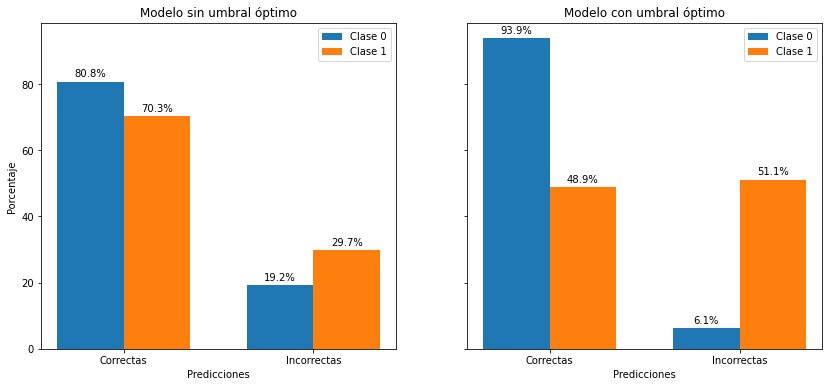

In [44]:
# Calcular las predicciones correctas e incorrectas para cada clase usando el umbral óptimo
correct_predictions_0_optimal = np.sum((y_test == y_pred_optimal) & (y_test == 0))
incorrect_predictions_0_optimal = np.sum((y_test != y_pred_optimal) & (y_test == 0))

correct_predictions_1_optimal = np.sum((y_test == y_pred_optimal) & (y_test == 1))
incorrect_predictions_1_optimal = np.sum((y_test != y_pred_optimal) & (y_test == 1))

# Calcular los porcentajes correctos e incorrectos para cada clase usando el umbral óptimo
correct_percentage_0_optimal = correct_predictions_0_optimal / total_predictions_0 * 100
incorrect_percentage_0_optimal = incorrect_predictions_0_optimal / total_predictions_0 * 100

correct_percentage_1_optimal = correct_predictions_1_optimal / total_predictions_1 * 100
incorrect_percentage_1_optimal = incorrect_predictions_1_optimal / total_predictions_1 * 100

# Crear un gráfico de barras para comparar el desempeño del modelo antes y después de aplicar el umbral óptimo
labels = ['Correctas', 'Incorrectas']
class_0_percentages_optimal = [correct_percentage_0_optimal, incorrect_percentage_0_optimal]
class_1_percentages_optimal = [correct_percentage_1_optimal, incorrect_percentage_1_optimal]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Gráfico de barras para el modelo antes de aplicar el umbral óptimo
rects1_original = ax1.bar(x - width/2, class_0_percentages, width, label='Clase 0')
rects2_original = ax1.bar(x + width/2, class_1_percentages, width, label='Clase 1')
ax1.set_title("Modelo sin umbral óptimo")
ax1.set_xlabel("Predicciones")
ax1.set_ylabel("Porcentaje")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
autolabel(rects1_original, ax1)
autolabel(rects2_original, ax1)

# Gráfico de barras para el modelo después de aplicar el umbral óptimo
rects1_optimal = ax2.bar(x - width/2, class_0_percentages_optimal, width, label='Clase 0')
rects2_optimal = ax2.bar(x + width/2, class_1_percentages_optimal, width, label='Clase 1')
ax2.set_title("Modelo con umbral óptimo")
ax2.set_xlabel("Predicciones")
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
autolabel(rects1_optimal, ax2)
autolabel(rects2_optimal, ax2)

plt.show()

Dado que el Modelo 1 utiliza una base de datos completa de 50,000 observaciones, es más representativo de la población real y puede proporcionar predicciones más confiables en general.

Si bien el Modelo 2 tiene un mejor rendimiento en la identificación de casos de default en su estado inicial, la base de datos más pequeña y equilibrada puede hacer que el modelo tenga un rendimiento inferior cuando se enfrenta a datos desequilibrados en la vida real.

Los gráficos de barras muestran la importancia de equilibrar la base de datos, ya que si lo hubieramos dejado como en el primer entrenamiento, el modelo se hubiera enfocado más en solo predecir la clase mayoritaria. Ahora el modelo mantiene el accuracy y el auc similar, pero las predicciones. Un enfoque diferente al submuestreo hubiera sido el sobremuestreo de la clase minoritaria a través de técnicas como Synthetic Minority Over-sampling Technique (SMOTE) o Adaptive Synthetic Sampling (ADASYN)

In [45]:
print(f'Predicciones Correctas No Default {class_0_percentages_optimal}')
print(f'Predicciones Correctas Default {class_1_percentages_optimal}')

Predicciones Correctas No Default [93.86393952867941, 6.136060471320587]
Predicciones Correctas Default [48.866727107887584, 51.13327289211242]


In [46]:
# Predecir las clases usando el umbral óptimo (0.23 - Minimizamos el riesgo)
probs_total = best_model.predict_proba(X)[:, 1]
probs_test = best_model.predict_proba(X_test)[:, 1]
predictions_optimal = np.where(probs_test >= optimal_threshold, 1, 0)

# Predecir las clases usando el umbral de 0.5 (Modelo Base)
predictions_05 = np.where(probs_test >= 0.5, 1, 0)

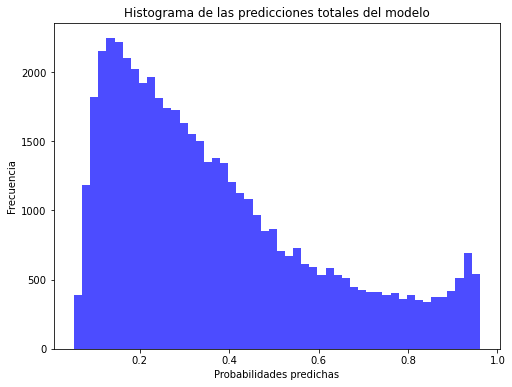

In [47]:
plt.figure(figsize=(8, 6))
plt.hist(probs_total, bins=50, color='blue', alpha=0.7)
plt.xlabel('Probabilidades predichas')
plt.ylabel('Frecuencia')
plt.title('Histograma de las predicciones totales del modelo')
plt.show()

In [48]:
# Asumimos una tasa de interés del 10%
interest_rate = 0.1

# Asumimos que el monto del préstamo es la deuda máxima
loan_amount = X_test['MAX_DEUNOREV_12M']

# Calculamos las ganancias y pérdidas para el umbral óptimo
true_positives = (predictions_optimal == 1) & (y_test == 1)
false_positives = (predictions_optimal == 1) & (y_test == 0)
true_negatives = (predictions_optimal == 0) & (y_test == 0)
false_negatives = (predictions_optimal == 0) & (y_test == 1)

# Ganancias: Intereses de los préstamos correctamente clasificados como 0 (buenos clientes)
gains = np.sum(loan_amount[true_negatives] * interest_rate)

# Pérdidas: Monto total de los préstamos incorrectamente clasificados como 0 (malos clientes)
losses = np.sum(loan_amount[false_negatives])

# Ganancia neta
net_gain = gains - losses

print(f"Ganancia neta utilizando el umbral óptimo: {net_gain:.2f}")


Ganancia neta utilizando el umbral óptimo: 561800.91


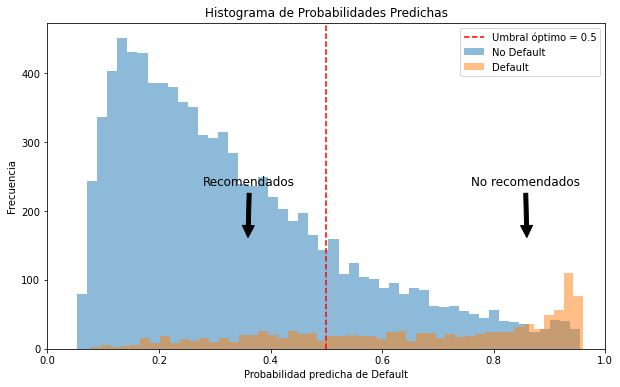

In [49]:
# Calcular las probabilidades predichas para la base de testeo
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# Crear el histograma
plt.figure(figsize=(10,6))
plt.hist(y_pred_proba[y_test==0], bins=50, label='No Default', alpha=0.5)
plt.hist(y_pred_proba[y_test==1], bins=50, label='Default', alpha=0.5)
plt.axvline(x=0.5, color='r', linestyle='--', label='Umbral óptimo = 0.5')

# Crear una anotación para indicar a quiénes se les recomendaría
plt.annotate('Recomendados', xy=(optimal_threshold/2, plt.ylim()[1]/3), 
             xytext=(optimal_threshold/2-0.08, plt.ylim()[1]/2), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')
plt.annotate('No recomendados', xy=((1+optimal_threshold)/2, plt.ylim()[1]/3), 
             xytext=((0.8+optimal_threshold)/2, plt.ylim()[1]/2), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')

# Configurar el gráfico
plt.xlabel('Probabilidad predicha de Default')
plt.ylabel('Frecuencia')
plt.title('Histograma de Probabilidades Predichas')
plt.legend(loc="upper right")
plt.xlim([0,1])  # Aseguramos que el gráfico se muestre completamente en el rango de 0 a 1
plt.show()



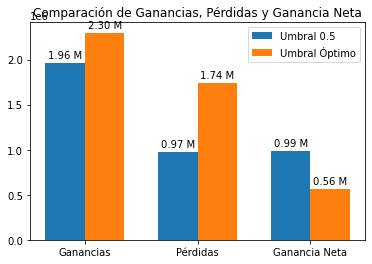

In [50]:
# Calcular las predicciones para el umbral de 0.5
predictions_05 = np.where(probs_test >= 0.5, 1, 0)

# Identificar verdaderos y falsos positivos y negativos para el umbral de 0.5
true_positives_05 = (predictions_05 == 1) & (y_test == 1)
false_positives_05 = (predictions_05 == 1) & (y_test == 0)
true_negatives_05 = (predictions_05 == 0) & (y_test == 0)
false_negatives_05 = (predictions_05 == 0) & (y_test == 1)

# Ganancias y pérdidas para el umbral de 0.5
gains_05 = np.sum(loan_amount[true_negatives_05] * interest_rate)
losses_05 = np.sum(loan_amount[false_negatives_05])
net_gain_05 = gains_05 - losses_05

# Crear un gráfico de barras
bar_width = 0.35
labels = ['Ganancias', 'Pérdidas', 'Ganancia Neta']
umbral_05 = [gains_05, losses_05, net_gain_05]
umbral_optimal = [gains, losses, net_gain]

fig, ax = plt.subplots()
bar1 = ax.bar(np.arange(len(umbral_05)), umbral_05, bar_width, label='Umbral 0.5')
bar2 = ax.bar(np.arange(len(umbral_optimal)) + bar_width, umbral_optimal, bar_width, label='Umbral Óptimo')

ax.set_xticks(np.arange(len(umbral_05)) + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

def autolabel2(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f} M'.format(height/1e6),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # desplazamiento vertical en puntos
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel2(bar1)
autolabel2(bar2)

plt.title("Comparación de Ganancias, Pérdidas y Ganancia Neta")
plt.show()


In [51]:
LGD = 1  # Asumimos que no recuperamos nada en caso de incumplimiento

# Usamos las predicciones de probabilidad de nuestro modelo como la PD
PD = best_model.predict_proba(X_test)[:, 1]

# Usamos el valor de la deuda como la EAD
EAD = X_test['MAX_DEUNOREV_12M']

# Calculamos la pérdida esperada
expected_loss = PD * EAD * LGD
print(f'La pérdida esperada es de {expected_loss.sum()}')

La pérdida esperada es de 11355853.461189296


# Casos estudiados que no tuvieron tan buenos resultados

## Prueba modelo óptimo con algunas variables normalizadas

Los resultados fueron prácticamente iguales que el modelo base

In [52]:
from sklearn.preprocessing import StandardScaler

# Definir las columnas a normalizar
cols_to_normalize = ['MAX_DEUNOREV_12M', 'MAX_DEU_JUD_24M', 'PROM_DEUREV_24M', 'PROM_DEUVNCD_12M', 
                    'RMAX_DREV_DDIR_24M', 'RMAX_DVNCD_DDIR_12M', 
                   'RTOT_DACT_DTOT_24M', 'RTOT_DVNCD_DDIR_12M', 'R_DREV_DDIR_24M', 'R_DVNCD_DDIR_12M']

# Crear el normalizador
scaler = StandardScaler()

# Ajustar y transformar los datos
data_clean_final[cols_to_normalize] = scaler.fit_transform(data_clean_final[cols_to_normalize])


In [53]:
# Separamos las características (X) y la variable objetivo (y)
X = data_clean_final.drop(['ID', 'FLG_CLI_DEF60'], axis=1)
y = data_clean_final['FLG_CLI_DEF60']

# Dividimos los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Entrenamiento y validación de cada modelo en el conjunto de validación
models = [
    ('Regresión Logística', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]
auc_scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append((name, auc))
    print(f'{name} AUC (validación): {auc}')

# Ordenamos los modelos por AUC en el conjunto de validación y seleccionamos el mejor
best_model_name, best_auc = sorted(auc_scores, key=lambda x: x[1], reverse=True)[0]
print(f'\nMejor modelo: {best_model_name} con AUC {best_auc}')

# Ajustar los hiperparámetros del mejor modelo
if best_model_name == 'Random Forest':
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10, random_state=42)
elif best_model_name == 'XGBoost':
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1]
    }
    random_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_dist, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10, random_state=42)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f'\nMejores hiperparámetros: {best_params}')

# Estimamos las probabilidades y calculamos el AUC del mejor modelo ajustado
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
best_auc_tuned = roc_auc_score(y_test, y_pred_proba_best)
print(f'AUC del mejor modelo ajustado en el conjunto de prueba: {best_auc_tuned}')

# Calculamos las métricas de rendimiento
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

C:\Users\User\anaconda3\envs\T\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Regresión Logística AUC (validación): 0.8043624893916399
Random Forest AUC (validación): 0.8319442255966252
XGBoost AUC (validación): 0.8512153975017113

Mejor modelo: XGBoost con AUC 0.8512153975017113
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores hiperparámetros: {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
AUC del mejor modelo ajustado en el conjunto de prueba: 0.8379233320984404
Accuracy: 0.9085057926527379
Precision: 0.693304535637149
Recall: 0.2910244786944696
F1-score: 0.40996168582375475


In [54]:
log_reg = LogisticRegression(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgb.fit(X_train, y_train)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_proba_rf = random_forest.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
# Calcular las curvas ROC para los modelos
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
log_reg_auc = roc_auc_score(y_test, y_pred_proba_log_reg)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

C:\Users\User\anaconda3\envs\T\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


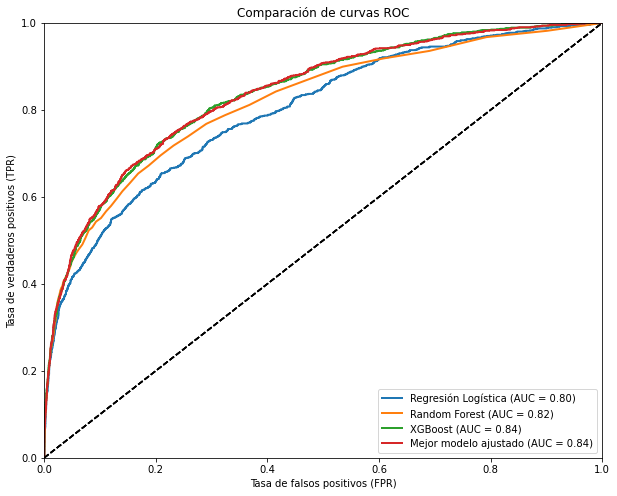

In [55]:
plt.figure(figsize=(10, 8))
plot_roc_curve(fpr_log_reg, tpr_log_reg, f'Regresión Logística (AUC = {log_reg_auc:.2f})')
plot_roc_curve(fpr_rf, tpr_rf, f'Random Forest (AUC = {rf_auc:.2f})')
plot_roc_curve(fpr_xgb, tpr_xgb, f'XGBoost (AUC = {xgb_auc:.2f})')
plot_roc_curve(fpr_best, tpr_best, f'Mejor modelo ajustado (AUC = {best_auc_tuned:.2f})')
plt.legend(loc='lower right')
plt.title('Comparación de curvas ROC')
plt.show()

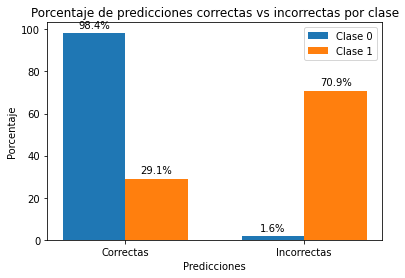

In [56]:
correct_predictions_0 = np.sum((y_test == y_pred) & (y_test == 0))
incorrect_predictions_0 = np.sum((y_test != y_pred) & (y_test == 0))
total_predictions_0 = np.sum(y_test == 0)

correct_predictions_1 = np.sum((y_test == y_pred) & (y_test == 1))
incorrect_predictions_1 = np.sum((y_test != y_pred) & (y_test == 1))
total_predictions_1 = np.sum(y_test == 1)

correct_percentage_0 = correct_predictions_0 / total_predictions_0 * 100
incorrect_percentage_0 = incorrect_predictions_0 / total_predictions_0 * 100

correct_percentage_1 = correct_predictions_1 / total_predictions_1 * 100
incorrect_percentage_1 = incorrect_predictions_1 / total_predictions_1 * 100

labels = ['Correctas', 'Incorrectas']
class_0_percentages = [correct_percentage_0, incorrect_percentage_0]
class_1_percentages = [correct_percentage_1, incorrect_percentage_1]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, class_0_percentages, width, label='Clase 0')
rects2 = ax.bar(x + width/2, class_1_percentages, width, label='Clase 1')

ax.set_xlabel("Predicciones")
ax.set_ylabel("Porcentaje")
ax.set_title("Porcentaje de predicciones correctas vs incorrectas por clase")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1, ax)
autolabel(rects2, ax)
plt.show()

In [57]:
print(f'Predicciones Correctas No Default {class_0_percentages}')
print(f'Predicciones Correctas Default {class_1_percentages}')

Predicciones Correctas No Default [98.42152067585593, 1.578479324144064]
Predicciones Correctas Default [29.102447869446962, 70.89755213055304]


In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)

# Calcular el F1-score para cada umbral
f1_scores = [f1_score(y_test, y_pred_proba_best >= t) for t in thresholds]

# Encontrar el índice del umbral óptimo (mayor F1-score)
optimal_threshold_index = np.argmax(f1_scores)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print(f"El umbral óptimo es: {optimal_threshold}")

El umbral óptimo es: 0.2446576952934265


In [59]:
y_pred_optimal = (y_pred_proba_best >= optimal_threshold).astype(int)
# Calcular el accuracy
accuracy_optimal_threshold = accuracy_score(y_test, y_pred_optimal)
precision_optimal_threshold = precision_score(y_test, y_pred_optimal)
recall_optimal_threshold = recall_score(y_test, y_pred_optimal)
f1_optimal_threshold = f1_score(y_test, y_pred_optimal)
print("Accuracy Umbral Óptimo:", accuracy_optimal_threshold)
print("Precision Umbral Óptimo:", precision_optimal_threshold)
print("Recall Umbral Óptimo:", recall_optimal_threshold)
print("F1-score Umbral Óptimo:", f1_optimal_threshold)

Accuracy Umbral Óptimo: 0.8930587186850183
Precision Umbral Óptimo: 0.510757717492984
Recall Umbral Óptimo: 0.49501359927470534
F1-score Umbral Óptimo: 0.5027624309392265


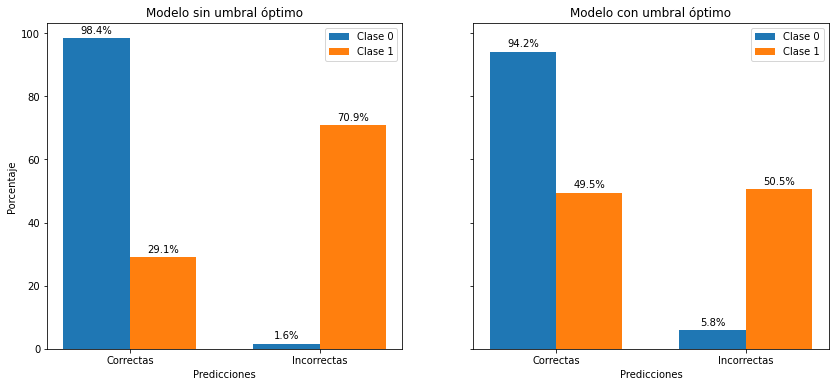

In [60]:
# Calcular las predicciones correctas e incorrectas para cada clase usando el umbral óptimo
correct_predictions_0_optimal = np.sum((y_test == y_pred_optimal) & (y_test == 0))
incorrect_predictions_0_optimal = np.sum((y_test != y_pred_optimal) & (y_test == 0))

correct_predictions_1_optimal = np.sum((y_test == y_pred_optimal) & (y_test == 1))
incorrect_predictions_1_optimal = np.sum((y_test != y_pred_optimal) & (y_test == 1))

# Calcular los porcentajes correctos e incorrectos para cada clase usando el umbral óptimo
correct_percentage_0_optimal = correct_predictions_0_optimal / total_predictions_0 * 100
incorrect_percentage_0_optimal = incorrect_predictions_0_optimal / total_predictions_0 * 100

correct_percentage_1_optimal = correct_predictions_1_optimal / total_predictions_1 * 100
incorrect_percentage_1_optimal = incorrect_predictions_1_optimal / total_predictions_1 * 100

# Crear un gráfico de barras para comparar el desempeño del modelo antes y después de aplicar el umbral óptimo
labels = ['Correctas', 'Incorrectas']
class_0_percentages_optimal = [correct_percentage_0_optimal, incorrect_percentage_0_optimal]
class_1_percentages_optimal = [correct_percentage_1_optimal, incorrect_percentage_1_optimal]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Gráfico de barras para el modelo antes de aplicar el umbral óptimo
rects1_original = ax1.bar(x - width/2, class_0_percentages, width, label='Clase 0')
rects2_original = ax1.bar(x + width/2, class_1_percentages, width, label='Clase 1')
ax1.set_title("Modelo sin umbral óptimo")
ax1.set_xlabel("Predicciones")
ax1.set_ylabel("Porcentaje")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
autolabel(rects1_original, ax1)
autolabel(rects2_original, ax1)

# Gráfico de barras para el modelo después de aplicar el umbral óptimo
rects1_optimal = ax2.bar(x - width/2, class_0_percentages_optimal, width, label='Clase 0')
rects2_optimal = ax2.bar(x + width/2, class_1_percentages_optimal, width, label='Clase 1')
ax2.set_title("Modelo con umbral óptimo")
ax2.set_xlabel("Predicciones")
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
autolabel(rects1_optimal, ax2)
autolabel(rects2_optimal, ax2)

plt.show()

In [61]:
print(f'Predicciones Correctas No Default {class_0_percentages_optimal}')
print(f'Predicciones Correctas Default {class_1_percentages_optimal}')

Predicciones Correctas No Default [94.18630502445531, 5.813694975544687]
Predicciones Correctas Default [49.50135992747053, 50.49864007252947]


### Prueba de sobremuestreo con ADASYN

Los resultados de subsampling fueron mucho mejores

In [62]:
from imblearn.over_sampling import ADASYN

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [64]:
# Parámetros para el ajuste de hiperparámetros con RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

# Crear el modelo XGBoost
xgb_model = XGBClassifier(random_state=42)

# Realizar el ajuste de hiperparámetros con RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, scoring='f1', n_jobs=-1, cv=5, verbose=10, random_state=42
)

random_search.fit(X_train_resampled, y_train_resampled)

# Mejor modelo encontrado
best_tuned = random_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred_best = best_tuned.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_pred_optimal)

print(f"Accuracy: {accuracy:.2f}, ROC AUC: {roc_auc:.2f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy: 0.81, ROC AUC: 0.51


In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score
acc = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)

# Calcular el recall
recall = recall_score(y_test, y_pred_best)

# Calcular el F1-score
f1 = f1_score(y_test, y_pred_best)

# Imprimir las métricas
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9070204970789187
Precision: 0.6546489563567363
Recall: 0.31306715063520874
F1-score: 0.423572744014733


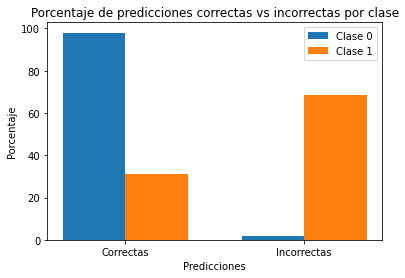

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que ya tienes las predicciones 'y_pred_best' y los valores reales 'y_test'
y_pred_best = best_tuned.predict(X_test)
# Calcular la proporción de predicciones correctas e incorrectas para cada clase
correct_predictions_0 = np.sum((y_test == y_pred_best) & (y_test == 0))
incorrect_predictions_0 = np.sum((y_test != y_pred_best) & (y_test == 0))
total_predictions_0 = np.sum(y_test == 0)

correct_predictions_1 = np.sum((y_test == y_pred_best) & (y_test == 1))
incorrect_predictions_1 = np.sum((y_test != y_pred_best) & (y_test == 1))
total_predictions_1 = np.sum(y_test == 1)

# Calcular los porcentajes
correct_percentage_0 = correct_predictions_0 / total_predictions_0 * 100
incorrect_percentage_0 = incorrect_predictions_0 / total_predictions_0 * 100

correct_percentage_1 = correct_predictions_1 / total_predictions_1 * 100
incorrect_percentage_1 = incorrect_predictions_1 / total_predictions_1 * 100

# Crear el gráfico de barras agrupadas
labels = ['Correctas', 'Incorrectas']
class_0_percentages = [correct_percentage_0, incorrect_percentage_0]
class_1_percentages = [correct_percentage_1, incorrect_percentage_1]

x = np.arange(len(labels))  # Ubicación de las etiquetas
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, class_0_percentages, width, label='Clase 0')
rects2 = ax.bar(x + width/2, class_1_percentages, width, label='Clase 1')

# Añadir texto, etiquetas, título y leyenda
ax.set_xlabel("Predicciones")
ax.set_ylabel("Porcentaje")
ax.set_title("Porcentaje de predicciones correctas vs incorrectas por clase")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Mostrar el gráfico
plt.show()

In [67]:
print(f'Predicciones Correctas No Default {class_0_percentages}')
print(f'Predicciones Correctas Default {class_1_percentages}')

Predicciones Correctas No Default [97.97710347893742, 2.0228965210625764]
Predicciones Correctas Default [31.306715063520873, 68.69328493647913]


In [68]:
y_pred_proba_best = best_tuned.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)

# Calcular el F1-score para cada umbral
f1_scores = [f1_score(y_test, y_pred_proba_best >= t) for t in thresholds]

# Encontrar el índice del umbral óptimo (mayor F1-score)
optimal_threshold_index = np.argmax(f1_scores)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print(f"El umbral óptimo es: {optimal_threshold}")

El umbral óptimo es: 0.2948460578918457


In [69]:
y_pred_optimal = (y_pred_proba_best >= optimal_threshold).astype(int)
# Calcular el accuracy
accuracy_optimal_threshold = accuracy_score(y_test, y_pred_optimal)
precision_optimal_threshold = precision_score(y_test, y_pred_optimal)
recall_optimal_threshold = recall_score(y_test, y_pred_optimal)
f1_optimal_threshold = f1_score(y_test, y_pred_optimal)
print("Accuracy Umbral Óptimo:", accuracy_optimal_threshold)
print("Precision Umbral Óptimo:", precision_optimal_threshold)
print("Recall Umbral Óptimo:", recall_optimal_threshold)
print("F1-score Umbral Óptimo:", f1_optimal_threshold)

Accuracy Umbral Óptimo: 0.8930587186850183
Precision Umbral Óptimo: 0.5106589147286822
Recall Umbral Óptimo: 0.4782214156079855
F1-score Umbral Óptimo: 0.4939081537019681


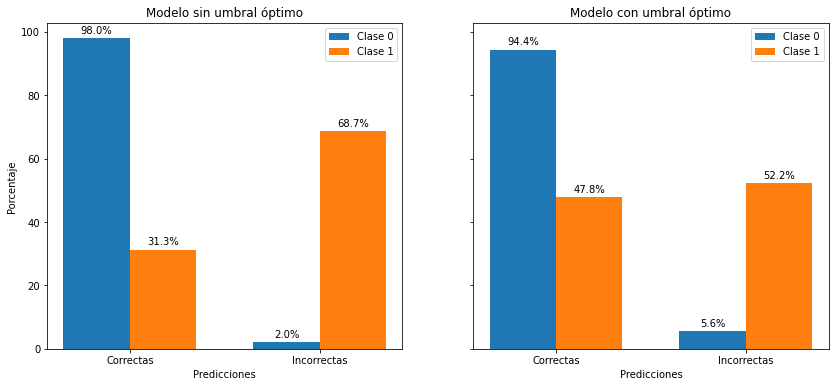

In [70]:
# Calcular las predicciones correctas e incorrectas para cada clase usando el umbral óptimo
correct_predictions_0_optimal = np.sum((y_test == y_pred_optimal) & (y_test == 0))
incorrect_predictions_0_optimal = np.sum((y_test != y_pred_optimal) & (y_test == 0))

correct_predictions_1_optimal = np.sum((y_test == y_pred_optimal) & (y_test == 1))
incorrect_predictions_1_optimal = np.sum((y_test != y_pred_optimal) & (y_test == 1))

# Calcular los porcentajes correctos e incorrectos para cada clase usando el umbral óptimo
correct_percentage_0_optimal = correct_predictions_0_optimal / total_predictions_0 * 100
incorrect_percentage_0_optimal = incorrect_predictions_0_optimal / total_predictions_0 * 100

correct_percentage_1_optimal = correct_predictions_1_optimal / total_predictions_1 * 100
incorrect_percentage_1_optimal = incorrect_predictions_1_optimal / total_predictions_1 * 100

# Crear un gráfico de barras para comparar el desempeño del modelo antes y después de aplicar el umbral óptimo
labels = ['Correctas', 'Incorrectas']
class_0_percentages_optimal = [correct_percentage_0_optimal, incorrect_percentage_0_optimal]
class_1_percentages_optimal = [correct_percentage_1_optimal, incorrect_percentage_1_optimal]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Gráfico de barras para el modelo antes de aplicar el umbral óptimo
rects1_original = ax1.bar(x - width/2, class_0_percentages, width, label='Clase 0')
rects2_original = ax1.bar(x + width/2, class_1_percentages, width, label='Clase 1')
ax1.set_title("Modelo sin umbral óptimo")
ax1.set_xlabel("Predicciones")
ax1.set_ylabel("Porcentaje")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
autolabel(rects1_original, ax1)
autolabel(rects2_original, ax1)

# Gráfico de barras para el modelo después de aplicar el umbral óptimo
rects1_optimal = ax2.bar(x - width/2, class_0_percentages_optimal, width, label='Clase 0')
rects2_optimal = ax2.bar(x + width/2, class_1_percentages_optimal, width, label='Clase 1')
ax2.set_title("Modelo con umbral óptimo")
ax2.set_xlabel("Predicciones")
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
autolabel(rects1_optimal, ax2)
autolabel(rects2_optimal, ax2)

plt.show()

In [71]:
print(f'Predicciones Correctas No Default {class_0_percentages_optimal}')
print(f'Predicciones Correctas Default {class_1_percentages_optimal}')

Predicciones Correctas No Default [94.38701789485384, 5.61298210514616]
Predicciones Correctas Default [47.82214156079855, 52.17785843920145]
